# <center> Age Classification using Deep Learning

## Introduction

<div style = "text-align: justify"> &emsp; <b> Deep Learning </b> is a state-of-art method that currently popular to solve many difficult problems. The area the widely use deep learning is autonomous driving car. It uses deep learning to classify the object in the image into order command the car to drive safely without accident. 
    <br><br>
In this assignment, we will use one of the deep learning method called <b>Convolution Neural Network (CNN) </b> to classify the age of the person in the image. Normally, CNN is uses to extract important features in the image the could be used for prediction. Therefore, to be able to extract many important features that could be used for predcition correctly, many images of the person are requied. Hence, we could use <b> pretrain model </b> and <b> image augmentation </b> to facilitate the generalization and accuracy of the model. Moreover, important features can be extracted by using filters and pooling.
<img src="images/cnn.png" width="560" height="360">
&emsp; The convolution works by sliding windows using the filter over the image which it will return element wise computation. Each patch is then transformed into 1D shape. The size of convolved feature is controlled by dept, stide and zero-padding. These are the reason that the output of convolute layer has has decrease in spatial volume. The activation function in convolution layer is typically <b>Rectified Linear Unit (ReLU)</b> which helps introduce non-linearlity in the model. Also, the dimensionlity output of convolved layer is reduced when using <b>pooling layer</b> which help in lower the computational work and reduce distortion to the network (reduce overfit). Then, the output is then flatten layer, transforms a two-dimensional matrix into a vector and fed into a fully connected neural network. Lastly, in the fully-connected layer will give a prediction.
<br>
<img src="images/convolution.gif" width="360" height="240">
<a href="http://deeplearning.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/">Reference</a>
<br>
<br>
Here, we will perform 3 type of models to see their classification performance.
<br>
1) <b>Model build from scratch</b><br>
2) <b>Pretrain Inception model</b><br>
3) <b>Pretrain VGG-Face</b><br>
<br>
&emsp; We choose Inception mode because it is created by Google and has less parameters to train than ResNet. VGG-Face model is used because it was trained from image of a person which has the same objective as our assignment. </div>

## Methodology

1) <b> Data Preprocessing </b><br>
- <i> Import images </i>
<br>The metadata of the images are in notepad which need to be extracted.<br>
<br>
- <i>Remove unlabeled data</i>
<br>There are some images that has no labels with it.<br>
<br>
- <i>Data Cleaning</i>
<br>Change the label into the correct class<br><br>

2) <b>Data Exploration </b><br>
<br>
3) <b>Data Prepration </b><br>
<i> Split data into three datasets: </i>
    - Training set - Model training
    - Validation set - Hyperparamter tuning
    - Test set - Model testing
<br>
4) <b> Model Development </b><br>
<br>
5) <b> Model Evaluation </b><br>
- Compare between LSTM and GRU in term of Accuracy, ROC and PR cruve.

### Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tqdm
import pickle
import joblib
import pandas as pd
import time
from itertools import cycle

import keras
from keras_tqdm import TQDMNotebookCallback
from keras.models import load_model
from keras import regularizers
from keras import layers
from keras import models
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import backend as K
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras.utils import to_categorical
from tensorflow import set_random_seed

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score, balanced_accuracy_score
import scikitplot as skplt
from scipy import interp

from utils import return_folder_info, imread, build_one_hot

In [173]:
# Set dataframe display

pd.set_option('display.max_columns', 10)  # default = 20
pd.set_option('display.expand_frame_repr', True) # default = True
pd.set_option('display.max_colwidth', -1) # default = 50

### Data Preprocessing

In [61]:
# Prepare reading datasets, metadata texts

prefix = "landmark_aligned_face."
metadata = ['fold_0_data.txt','fold_1_data.txt','fold_2_data.txt','fold_3_data.txt','fold_4_data.txt']
classes = ["(0, 2)", "(4, 6)", "(8, 12)", "(15, 20)", "(25, 32)", "(38, 43)", "(48, 53)", "(60, 100)"]
path_faces = "D:/Download/Data/aligned"

In [ ]:
# Since there are labels that do not match the classes stated, need to fix them

classes_to_fix = {'35': classes[5], '3': classes[0], '55': classes[7], '58': classes[7], 
'22': classes[3], '13': classes[2], '45': classes[5], '36': classes[5], 
'23': classes[4], '57': classes[7], '56': classes[6], '2': classes[0], 
'29': classes[4], '34': classes[4], '42': classes[5], '46': classes[6], 
'32': classes[4], '(38, 48)': classes[5], '(38, 42)': classes[5], '(8, 23)': classes[2],
 '(27, 32)': classes[4]}

In [ ]:
# All file location are stored as a list for furthur used.

all_folders = []
for textfile in metadata:
    folder, none_count = return_folder_info(textfile)
    all_folders.append(folder)
print("A sample:", all_folders[0][0])
print("No. of Pics without Age Group Label:", none_count)

In [ ]:
# We we wil perform import the image using the file's location. The image will be resize into 244x244
# The label will be converted in one-hot vector.

width, height = 224, 224

all_data = []
all_labels = []
print("Start reading images data...")
for folder in all_folders:
    data = []
    labels = []
    for i in tqdm.tqdm(range(len(folder))):    # here using tqdm to monitor progress
        img = imread(folder[i][0], width, height)
        one_hot = build_one_hot(folder[i][1])
        data.append(img)
        labels.append(one_hot)
    all_data.append(data)
    all_labels.append(labels)
    print("One folder done...")
print("All done!")

In [ ]:
# Convert the data and labels from list of list into single list.

X = [all_data[i][j] for i in range(len(all_data)) for j in range(len(all_data[i]))]
y = [all_labels[i][j] for i in range(len(all_labels)) for j in range(len(all_labels[i]))]

# The labels are converted into numpy array

X = np.array(X)
y = np.array(y)

In [ ]:
np.save("all_data_np", X)
np.save("all_label_np", y)

In [3]:
# Import numpy file 

X = np.load(r'D:\Download\Data\all_data_np.npy')
y = np.load(r'D:\Download\Data\all_label_np.npy')

### Visualize the data

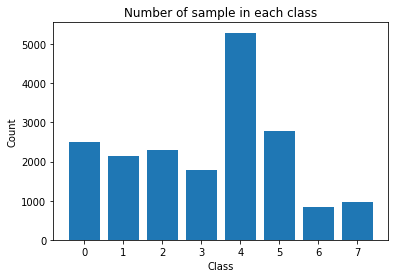

4    5296
5    2783
0    2509
2    2293
1    2140
3    1791
7     977
6     833
Name: 0, dtype: int64


In [3]:
# Visualize the number of sample in each class

class_name = ["(0, 2)", "(4, 6)", "(8, 12)", "(15, 20)", "(25, 32)", "(38, 43)", "(48, 53)", "(60, 100)"]

y_count = np.asarray([np.where(r==1)[0][0] for r in y])
y_df = pd.DataFrame(y_count)
count = y_df[0].value_counts()
count_dict = count.to_dict()

plt.bar(count.index.values, count, align='center', label= f'Class: {class_name}')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of sample in each class')
plt.show()

print(count)

The class age range 25-32 has the highest sample of 5000 images. Whereas, other class has around 2500 images. The last two classes has the lowest number of samples, only around 1000 images.

### Split data into Train, Valiate and Teset set

In [4]:
# We split the data into proportion of 80:10:10

X_train, X, y_train, y = train_test_split(
        X, y, test_size=0.2, random_state=28, stratify = y)

X_validate, X_test, y_validate, y_test = train_test_split(
        X, y, test_size=0.5, random_state=28, stratify = y)

# We delete unused variable as it will help in increase the memory
del X

### Augmentation

In [5]:
# We perform data augmentation to generate more samples which could help to get better accuracy and f1 score.

datagen = ImageDataGenerator(
        rotation_range=6,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1)

batch_size = 128

# .flow function will generate augmented imaged from the memmory. This means that this method use consume a lot of memmory.
# If memory is not enough, use .flow_from_directory is recommended as this method will read and augment the image from directory.
# The requirement is the folder structure of the image need contruct in the same format as Keras required.

augmentation = datagen.flow(X_train, y_train, batch_size=batch_size, seed=28)

### Convolutional Neural Network (CNN)

#### Train from Scratch

In [6]:
# Create model from scratch
# The filters are increasing in each layer so that the complex features are capture in the top layer.
# Also, we use 3x3 filter with the kernel of 2x2 to reduce the filter size in the deep layer.

np.random.seed(28)
set_random_seed(28)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.compile(optimizer = "adam", loss="categorical_crossentropy", metrics = ['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxP

In [8]:
filepath = r".\models\shallow_model\jupyter_adam_dropout_aug2_{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose = 1)

history = model.fit_generator(augmentation ,
                              validation_data=[X_validate, y_validate],
                              epochs = 100,
                              steps_per_epoch=len(X_train) / batch_size,
                              callbacks=[checkpoint,TQDMNotebookCallback()], verbose = 2,
                              workers = 12)

Epoch 1/100


 - 27s - loss: 1.9389 - acc: 0.2853 - val_loss: 1.9339 - val_acc: 0.2841

Epoch 00001: val_loss improved from inf to 1.93390, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_01-1.93-0.28.h5
Epoch 2/100


 - 24s - loss: 1.9232 - acc: 0.2858 - val_loss: 1.8815 - val_acc: 0.3061

Epoch 00002: val_loss improved from 1.93390 to 1.88150, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_02-1.88-0.31.h5
Epoch 3/100


 - 24s - loss: 1.8530 - acc: 0.3151 - val_loss: 1.7534 - val_acc: 0.3507

Epoch 00003: val_loss improved from 1.88150 to 1.75344, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_03-1.75-0.35.h5
Epoch 4/100


 - 24s - loss: 1.6774 - acc: 0.3777 - val_loss: 1.5569 - val_acc: 0.4098

Epoch 00004: val_loss improved from 1.75344 to 1.55689, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_04-1.56-0.41.h5
Epoch 5/100


 - 24s - loss: 1.5305 - acc: 0.4251 - val_loss: 1.4515 - val_acc: 0.4447

Epoch 00005: val_loss improved from 1.55689 to 1.45155, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_05-1.45-0.44.h5
Epoch 6/100


 - 24s - loss: 1.4540 - acc: 0.4472 - val_loss: 1.3843 - val_acc: 0.4791

Epoch 00006: val_loss improved from 1.45155 to 1.38432, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_06-1.38-0.48.h5
Epoch 7/100


 - 24s - loss: 1.3923 - acc: 0.4636 - val_loss: 1.3255 - val_acc: 0.4995

Epoch 00007: val_loss improved from 1.38432 to 1.32551, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_07-1.33-0.50.h5
Epoch 8/100


 - 24s - loss: 1.3190 - acc: 0.4974 - val_loss: 1.2477 - val_acc: 0.5124

Epoch 00008: val_loss improved from 1.32551 to 1.24771, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_08-1.25-0.51.h5
Epoch 9/100


 - 24s - loss: 1.2863 - acc: 0.5004 - val_loss: 1.2298 - val_acc: 0.5258

Epoch 00009: val_loss improved from 1.24771 to 1.22978, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_09-1.23-0.53.h5
Epoch 10/100


 - 24s - loss: 1.2356 - acc: 0.5256 - val_loss: 1.1793 - val_acc: 0.5483

Epoch 00010: val_loss improved from 1.22978 to 1.17925, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_10-1.18-0.55.h5
Epoch 11/100


 - 24s - loss: 1.1916 - acc: 0.5359 - val_loss: 1.1238 - val_acc: 0.5569

Epoch 00011: val_loss improved from 1.17925 to 1.12384, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_11-1.12-0.56.h5
Epoch 12/100


 - 23s - loss: 1.1639 - acc: 0.5521 - val_loss: 1.1979 - val_acc: 0.5467

Epoch 00012: val_loss did not improve from 1.12384
Epoch 13/100


 - 24s - loss: 1.1382 - acc: 0.5589 - val_loss: 1.1079 - val_acc: 0.5553

Epoch 00013: val_loss improved from 1.12384 to 1.10790, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_13-1.11-0.56.h5
Epoch 14/100


 - 24s - loss: 1.0849 - acc: 0.5755 - val_loss: 1.0718 - val_acc: 0.5773

Epoch 00014: val_loss improved from 1.10790 to 1.07178, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_14-1.07-0.58.h5
Epoch 15/100


 - 24s - loss: 1.0668 - acc: 0.5820 - val_loss: 1.0644 - val_acc: 0.5875

Epoch 00015: val_loss improved from 1.07178 to 1.06443, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_15-1.06-0.59.h5
Epoch 16/100


 - 24s - loss: 1.0346 - acc: 0.5961 - val_loss: 1.0020 - val_acc: 0.6053

Epoch 00016: val_loss improved from 1.06443 to 1.00200, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_16-1.00-0.61.h5
Epoch 17/100


 - 24s - loss: 1.0135 - acc: 0.5980 - val_loss: 1.0054 - val_acc: 0.6160

Epoch 00017: val_loss did not improve from 1.00200
Epoch 18/100


 - 24s - loss: 0.9987 - acc: 0.6065 - val_loss: 1.0018 - val_acc: 0.6090

Epoch 00018: val_loss improved from 1.00200 to 1.00180, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_18-1.00-0.61.h5
Epoch 19/100


 - 24s - loss: 0.9680 - acc: 0.6142 - val_loss: 0.9860 - val_acc: 0.6079

Epoch 00019: val_loss improved from 1.00180 to 0.98605, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_19-0.99-0.61.h5
Epoch 20/100


 - 24s - loss: 0.9382 - acc: 0.6298 - val_loss: 0.9711 - val_acc: 0.6155

Epoch 00020: val_loss improved from 0.98605 to 0.97108, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_20-0.97-0.62.h5
Epoch 21/100


 - 24s - loss: 0.9313 - acc: 0.6348 - val_loss: 0.9399 - val_acc: 0.6257

Epoch 00021: val_loss improved from 0.97108 to 0.93994, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_21-0.94-0.63.h5
Epoch 22/100


 - 24s - loss: 0.8868 - acc: 0.6525 - val_loss: 0.9677 - val_acc: 0.6069

Epoch 00022: val_loss did not improve from 0.93994
Epoch 23/100


 - 24s - loss: 0.8959 - acc: 0.6497 - val_loss: 0.9254 - val_acc: 0.6353

Epoch 00023: val_loss improved from 0.93994 to 0.92541, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_23-0.93-0.64.h5
Epoch 24/100


 - 24s - loss: 0.8775 - acc: 0.6569 - val_loss: 0.9650 - val_acc: 0.6257

Epoch 00024: val_loss did not improve from 0.92541
Epoch 25/100


 - 24s - loss: 0.8575 - acc: 0.6613 - val_loss: 0.8971 - val_acc: 0.6386

Epoch 00025: val_loss improved from 0.92541 to 0.89710, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_25-0.90-0.64.h5
Epoch 26/100


 - 24s - loss: 0.8500 - acc: 0.6651 - val_loss: 0.9366 - val_acc: 0.6289

Epoch 00026: val_loss did not improve from 0.89710
Epoch 27/100


 - 24s - loss: 0.8226 - acc: 0.6746 - val_loss: 0.9085 - val_acc: 0.6391

Epoch 00027: val_loss did not improve from 0.89710
Epoch 28/100


 - 24s - loss: 0.7976 - acc: 0.6863 - val_loss: 0.8867 - val_acc: 0.6423

Epoch 00028: val_loss improved from 0.89710 to 0.88675, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_28-0.89-0.64.h5
Epoch 29/100


 - 24s - loss: 0.7958 - acc: 0.6896 - val_loss: 0.9187 - val_acc: 0.6472

Epoch 00029: val_loss did not improve from 0.88675
Epoch 30/100


 - 24s - loss: 0.7725 - acc: 0.6985 - val_loss: 0.9042 - val_acc: 0.6493

Epoch 00030: val_loss did not improve from 0.88675
Epoch 31/100


 - 24s - loss: 0.7764 - acc: 0.6966 - val_loss: 0.8692 - val_acc: 0.6541

Epoch 00031: val_loss improved from 0.88675 to 0.86924, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_31-0.87-0.65.h5
Epoch 32/100


 - 24s - loss: 0.7465 - acc: 0.7067 - val_loss: 0.8643 - val_acc: 0.6660

Epoch 00032: val_loss improved from 0.86924 to 0.86431, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_32-0.86-0.67.h5
Epoch 33/100


 - 24s - loss: 0.7352 - acc: 0.7099 - val_loss: 0.8620 - val_acc: 0.6702

Epoch 00033: val_loss improved from 0.86431 to 0.86202, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_33-0.86-0.67.h5
Epoch 34/100


 - 24s - loss: 0.7259 - acc: 0.7189 - val_loss: 0.8691 - val_acc: 0.6724

Epoch 00034: val_loss did not improve from 0.86202
Epoch 35/100


 - 24s - loss: 0.7184 - acc: 0.7199 - val_loss: 0.8577 - val_acc: 0.6638

Epoch 00035: val_loss improved from 0.86202 to 0.85767, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_35-0.86-0.66.h5
Epoch 36/100


 - 24s - loss: 0.7017 - acc: 0.7268 - val_loss: 0.8624 - val_acc: 0.6724

Epoch 00036: val_loss did not improve from 0.85767
Epoch 37/100


 - 24s - loss: 0.6970 - acc: 0.7297 - val_loss: 0.8647 - val_acc: 0.6745

Epoch 00037: val_loss did not improve from 0.85767
Epoch 38/100


 - 24s - loss: 0.6786 - acc: 0.7403 - val_loss: 0.8603 - val_acc: 0.6617

Epoch 00038: val_loss did not improve from 0.85767
Epoch 39/100


 - 24s - loss: 0.6811 - acc: 0.7350 - val_loss: 0.8794 - val_acc: 0.6574

Epoch 00039: val_loss did not improve from 0.85767
Epoch 40/100


 - 24s - loss: 0.6665 - acc: 0.7391 - val_loss: 0.8245 - val_acc: 0.6745

Epoch 00040: val_loss improved from 0.85767 to 0.82447, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_40-0.82-0.67.h5
Epoch 41/100


 - 24s - loss: 0.6529 - acc: 0.7496 - val_loss: 0.8710 - val_acc: 0.6697

Epoch 00041: val_loss did not improve from 0.82447
Epoch 42/100


 - 24s - loss: 0.6441 - acc: 0.7507 - val_loss: 0.8723 - val_acc: 0.6600

Epoch 00042: val_loss did not improve from 0.82447
Epoch 43/100


 - 24s - loss: 0.6231 - acc: 0.7610 - val_loss: 0.8683 - val_acc: 0.6794

Epoch 00043: val_loss did not improve from 0.82447
Epoch 44/100


 - 24s - loss: 0.6179 - acc: 0.7605 - val_loss: 0.8887 - val_acc: 0.6692

Epoch 00044: val_loss did not improve from 0.82447
Epoch 45/100


 - 24s - loss: 0.6219 - acc: 0.7620 - val_loss: 0.8686 - val_acc: 0.6799

Epoch 00045: val_loss did not improve from 0.82447
Epoch 46/100


 - 24s - loss: 0.6145 - acc: 0.7591 - val_loss: 0.8192 - val_acc: 0.6928

Epoch 00046: val_loss improved from 0.82447 to 0.81920, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_46-0.82-0.69.h5
Epoch 47/100


 - 24s - loss: 0.6053 - acc: 0.7708 - val_loss: 0.8528 - val_acc: 0.6762

Epoch 00047: val_loss did not improve from 0.81920
Epoch 48/100


 - 24s - loss: 0.5997 - acc: 0.7668 - val_loss: 0.8726 - val_acc: 0.6708

Epoch 00048: val_loss did not improve from 0.81920
Epoch 49/100


 - 24s - loss: 0.5826 - acc: 0.7735 - val_loss: 0.8464 - val_acc: 0.6885

Epoch 00049: val_loss did not improve from 0.81920
Epoch 50/100


 - 24s - loss: 0.5828 - acc: 0.7772 - val_loss: 0.8582 - val_acc: 0.6821

Epoch 00050: val_loss did not improve from 0.81920
Epoch 51/100


 - 24s - loss: 0.5723 - acc: 0.7831 - val_loss: 0.8140 - val_acc: 0.6890

Epoch 00051: val_loss improved from 0.81920 to 0.81401, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_51-0.81-0.69.h5
Epoch 52/100


 - 24s - loss: 0.5586 - acc: 0.7885 - val_loss: 0.8326 - val_acc: 0.6869

Epoch 00052: val_loss did not improve from 0.81401
Epoch 53/100


 - 24s - loss: 0.5492 - acc: 0.7921 - val_loss: 0.8803 - val_acc: 0.6890

Epoch 00053: val_loss did not improve from 0.81401
Epoch 54/100


 - 24s - loss: 0.5511 - acc: 0.7873 - val_loss: 0.8297 - val_acc: 0.6944

Epoch 00054: val_loss did not improve from 0.81401
Epoch 55/100


 - 24s - loss: 0.5272 - acc: 0.8001 - val_loss: 0.8636 - val_acc: 0.6939

Epoch 00055: val_loss did not improve from 0.81401
Epoch 56/100


 - 24s - loss: 0.5428 - acc: 0.7918 - val_loss: 0.8340 - val_acc: 0.6917

Epoch 00056: val_loss did not improve from 0.81401
Epoch 57/100


 - 24s - loss: 0.5311 - acc: 0.7979 - val_loss: 0.8674 - val_acc: 0.6907

Epoch 00057: val_loss did not improve from 0.81401
Epoch 58/100


 - 24s - loss: 0.5195 - acc: 0.8084 - val_loss: 0.8438 - val_acc: 0.7025

Epoch 00058: val_loss did not improve from 0.81401
Epoch 59/100


 - 24s - loss: 0.5211 - acc: 0.8002 - val_loss: 0.8335 - val_acc: 0.6923

Epoch 00059: val_loss did not improve from 0.81401
Epoch 60/100


 - 24s - loss: 0.4976 - acc: 0.8128 - val_loss: 0.8356 - val_acc: 0.7030

Epoch 00060: val_loss did not improve from 0.81401
Epoch 61/100


 - 24s - loss: 0.5081 - acc: 0.8054 - val_loss: 0.8626 - val_acc: 0.6885

Epoch 00061: val_loss did not improve from 0.81401
Epoch 62/100


 - 24s - loss: 0.4905 - acc: 0.8127 - val_loss: 0.8301 - val_acc: 0.7019

Epoch 00062: val_loss did not improve from 0.81401
Epoch 63/100


 - 24s - loss: 0.4803 - acc: 0.8188 - val_loss: 0.8536 - val_acc: 0.6966

Epoch 00063: val_loss did not improve from 0.81401
Epoch 64/100


 - 24s - loss: 0.4779 - acc: 0.8167 - val_loss: 0.8249 - val_acc: 0.7095

Epoch 00064: val_loss did not improve from 0.81401
Epoch 65/100


 - 24s - loss: 0.4809 - acc: 0.8195 - val_loss: 0.8270 - val_acc: 0.6992

Epoch 00065: val_loss did not improve from 0.81401
Epoch 66/100


 - 24s - loss: 0.4729 - acc: 0.8216 - val_loss: 0.8117 - val_acc: 0.6987

Epoch 00066: val_loss improved from 0.81401 to 0.81168, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_66-0.81-0.70.h5
Epoch 67/100


 - 24s - loss: 0.4625 - acc: 0.8252 - val_loss: 0.7944 - val_acc: 0.7073

Epoch 00067: val_loss improved from 0.81168 to 0.79437, saving model to .\models\shallow_model\jupyter_adam_dropout_aug2_67-0.79-0.71.h5
Epoch 68/100


 - 24s - loss: 0.4650 - acc: 0.8276 - val_loss: 0.8233 - val_acc: 0.7095

Epoch 00068: val_loss did not improve from 0.79437
Epoch 69/100


 - 24s - loss: 0.4548 - acc: 0.8297 - val_loss: 0.8451 - val_acc: 0.7100

Epoch 00069: val_loss did not improve from 0.79437
Epoch 70/100


 - 24s - loss: 0.4493 - acc: 0.8308 - val_loss: 0.8760 - val_acc: 0.6928

Epoch 00070: val_loss did not improve from 0.79437
Epoch 71/100


 - 24s - loss: 0.4508 - acc: 0.8305 - val_loss: 0.8283 - val_acc: 0.7057

Epoch 00071: val_loss did not improve from 0.79437
Epoch 72/100


 - 24s - loss: 0.4481 - acc: 0.8355 - val_loss: 0.8414 - val_acc: 0.7143

Epoch 00072: val_loss did not improve from 0.79437
Epoch 73/100


 - 24s - loss: 0.4346 - acc: 0.8371 - val_loss: 0.8600 - val_acc: 0.7116

Epoch 00073: val_loss did not improve from 0.79437
Epoch 74/100


 - 24s - loss: 0.4336 - acc: 0.8372 - val_loss: 0.8270 - val_acc: 0.7035

Epoch 00074: val_loss did not improve from 0.79437
Epoch 75/100


 - 24s - loss: 0.4494 - acc: 0.8316 - val_loss: 0.8771 - val_acc: 0.6853

Epoch 00075: val_loss did not improve from 0.79437
Epoch 76/100


 - 24s - loss: 0.4250 - acc: 0.8423 - val_loss: 0.8718 - val_acc: 0.7052

Epoch 00076: val_loss did not improve from 0.79437
Epoch 77/100


 - 24s - loss: 0.4255 - acc: 0.8428 - val_loss: 0.8557 - val_acc: 0.6928

Epoch 00077: val_loss did not improve from 0.79437
Epoch 78/100


 - 24s - loss: 0.4140 - acc: 0.8423 - val_loss: 0.8690 - val_acc: 0.7003

Epoch 00078: val_loss did not improve from 0.79437
Epoch 79/100


 - 24s - loss: 0.4109 - acc: 0.8471 - val_loss: 0.8547 - val_acc: 0.7132

Epoch 00079: val_loss did not improve from 0.79437
Epoch 80/100


 - 24s - loss: 0.4219 - acc: 0.8437 - val_loss: 0.8410 - val_acc: 0.7084

Epoch 00080: val_loss did not improve from 0.79437
Epoch 81/100


 - 24s - loss: 0.4132 - acc: 0.8459 - val_loss: 0.8730 - val_acc: 0.7052

Epoch 00081: val_loss did not improve from 0.79437
Epoch 82/100


 - 24s - loss: 0.4025 - acc: 0.8507 - val_loss: 0.8498 - val_acc: 0.7164

Epoch 00082: val_loss did not improve from 0.79437
Epoch 83/100


 - 24s - loss: 0.3944 - acc: 0.8519 - val_loss: 0.8576 - val_acc: 0.7062

Epoch 00083: val_loss did not improve from 0.79437
Epoch 84/100


 - 24s - loss: 0.3992 - acc: 0.8543 - val_loss: 0.8881 - val_acc: 0.6987

Epoch 00084: val_loss did not improve from 0.79437
Epoch 85/100


 - 24s - loss: 0.3810 - acc: 0.8570 - val_loss: 0.9024 - val_acc: 0.7078

Epoch 00085: val_loss did not improve from 0.79437
Epoch 86/100


 - 24s - loss: 0.3943 - acc: 0.8547 - val_loss: 0.8425 - val_acc: 0.7137

Epoch 00086: val_loss did not improve from 0.79437
Epoch 87/100


 - 24s - loss: 0.3876 - acc: 0.8582 - val_loss: 0.8260 - val_acc: 0.7191

Epoch 00087: val_loss did not improve from 0.79437
Epoch 88/100


 - 24s - loss: 0.3855 - acc: 0.8548 - val_loss: 0.9181 - val_acc: 0.6901

Epoch 00088: val_loss did not improve from 0.79437
Epoch 89/100


 - 24s - loss: 0.3820 - acc: 0.8586 - val_loss: 0.8776 - val_acc: 0.7035

Epoch 00089: val_loss did not improve from 0.79437
Epoch 90/100


 - 24s - loss: 0.3797 - acc: 0.8605 - val_loss: 0.8232 - val_acc: 0.7111

Epoch 00090: val_loss did not improve from 0.79437
Epoch 91/100


 - 24s - loss: 0.3632 - acc: 0.8646 - val_loss: 0.8726 - val_acc: 0.7089

Epoch 00091: val_loss did not improve from 0.79437
Epoch 92/100


 - 24s - loss: 0.3672 - acc: 0.8641 - val_loss: 0.8905 - val_acc: 0.6966

Epoch 00092: val_loss did not improve from 0.79437
Epoch 93/100


 - 24s - loss: 0.3599 - acc: 0.8699 - val_loss: 0.8794 - val_acc: 0.6976

Epoch 00093: val_loss did not improve from 0.79437
Epoch 94/100


 - 24s - loss: 0.3556 - acc: 0.8675 - val_loss: 0.8487 - val_acc: 0.7266

Epoch 00094: val_loss did not improve from 0.79437
Epoch 95/100


 - 24s - loss: 0.3545 - acc: 0.8684 - val_loss: 0.8722 - val_acc: 0.7207

Epoch 00095: val_loss did not improve from 0.79437
Epoch 96/100


 - 24s - loss: 0.3641 - acc: 0.8684 - val_loss: 0.8564 - val_acc: 0.7213

Epoch 00096: val_loss did not improve from 0.79437
Epoch 97/100


 - 24s - loss: 0.3526 - acc: 0.8734 - val_loss: 0.8572 - val_acc: 0.7191

Epoch 00097: val_loss did not improve from 0.79437
Epoch 98/100


 - 24s - loss: 0.3569 - acc: 0.8699 - val_loss: 0.8514 - val_acc: 0.7095

Epoch 00098: val_loss did not improve from 0.79437
Epoch 99/100


 - 24s - loss: 0.3604 - acc: 0.8690 - val_loss: 0.9036 - val_acc: 0.7095

Epoch 00099: val_loss did not improve from 0.79437
Epoch 100/100


 - 24s - loss: 0.3318 - acc: 0.8800 - val_loss: 0.8671 - val_acc: 0.7154

Epoch 00100: val_loss did not improve from 0.79437


In [9]:
# Save model history

joblib.dump(history, 'models/shallow_model/jupyter_adam_dropout_aug2_shallow.pkl')

['models/shallow_model/jupyter_adam_dropout_aug2_shallow.pkl']

In [10]:
# Load model history

history = joblib.load(r'./models/shallow_model/jupyter_adam_dropout_aug2_shallow.pkl')

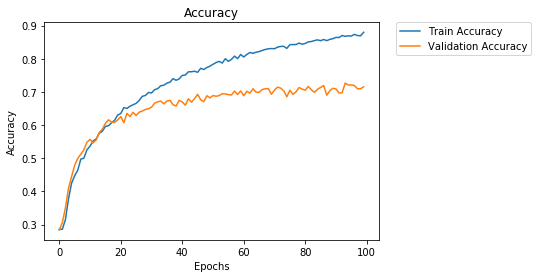

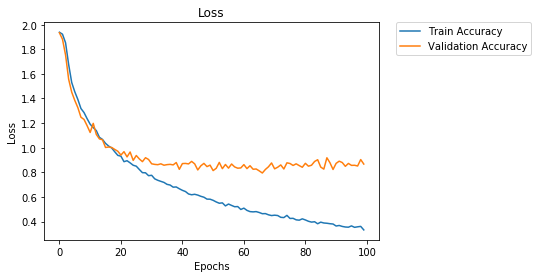

In [11]:
# Visualize train and validation accuracy and loss

epoch_list = list(range(len(history.history['acc'])))
plt.plot(epoch_list, history.history['acc'], label='Train Accuracy')
plt.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

epoch_list = list(range(len(history.history['loss'])))
plt.plot(epoch_list, history.history['loss'], label='Train Accuracy')
plt.plot(epoch_list, history.history['val_loss'], label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [55]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
validate_loss, validate_accuracy = model.evaluate(X_validate, y_validate)

1862/1862 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 1ms/step


In [56]:
print(f"Training accuracy and loss are {round(train_accuracy,2)}, {round(train_loss,2)}, respectively")
print(f"Validation accuracy and loss are {round(validate_accuracy,2)}, {round(validate_loss,2)}, respectively")

Training accuracy and loss are 0.91, 0.27, respectively
Validation accuracy and loss are 0.74, 0.76, respectively


The results show a promising training and validation loss and accuracy. However, after around 40 epochs, it start to overfit or reach the local optimum  becasue the loss in training set is a lot lower than validate loss.

_______________________
_______________________

### InceptionResNetV2

<img src="./images/inception_resnet_v2.png" width="800" height="600">
<img src="./images/residual_connection.png" width="360" height="240">

<a href="https://ai.googleblog.com/2016/08/improving-inception-and-image.html">Reference1</a>
<br>
<a href="http://arxiv.org/abs/1602.07261">Reference2</a>

The figure above illustrates the architecture of the InceptionResNetV2 model. This pretrain model is a variation of inception model that contain residual connection. The resiudal connections allow shortcuts of the weight sending into the another layer. Residual connection prevent the major problem of vanishing gradient and it has been tested to give a better performance.

In [15]:
# Call InceptiomResnetV2 model from Keras and use imagenet weight
# We use many dropout lavers with regularizer to prevent overfitting

# Fine tuning
np.random.seed(28)
set_random_seed(28)

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
x = base_model.output
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Find the layer index to unfreeze some of it.

for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_7
2 batch_normalization_1
3 activation_8
4 conv2d_8
5 batch_normalization_2
6 activation_9
7 conv2d_9
8 batch_normalization_3
9 activation_10
10 max_pooling2d_7
11 conv2d_10
12 batch_normalization_4
13 activation_11
14 conv2d_11
15 batch_normalization_5
16 activation_12
17 max_pooling2d_8
18 conv2d_15
19 batch_normalization_9
20 activation_16
21 conv2d_13
22 conv2d_16
23 batch_normalization_7
24 batch_normalization_10
25 activation_14
26 activation_17
27 average_pooling2d_1
28 conv2d_12
29 conv2d_14
30 conv2d_17
31 conv2d_18
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_13
37 activation_15
38 activation_18
39 activation_19
40 mixed_5b
41 conv2d_22
42 batch_normalization_16
43 activation_23
44 conv2d_20
45 conv2d_23
46 batch_normalization_14
47 batch_normalization_17
48 activation_21
49 activation_24
50 conv2d_19
51 conv2d_21
52 conv2d_24
53 batch_normalization_13
54 batch_normalization_15
55 batch_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
# There are total of 749 layers, we unfreeze around 25% of the total layers.

for layer in model.layers[:566]:
    layer.trainable = False
for layer in model.layers[566:]:
    layer.trainable = True

# we use very low learning rate as we use pretrain model

model.compile(optimizer = optimizers.Adam(lr = 0.0001), loss="categorical_crossentropy", metrics = ['accuracy'])
#model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum=0.9), loss="categorical_crossentropy", metrics = ['accuracy'])
#model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum=0.9), loss="categorical_crossentropy", metrics = [f1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_8 (

__________________________________________________________________________________________________
activation_26 (Activation)      (None, None, None, 3 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
activation_28 (Activation)      (None, None, None, 3 0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
activation_31 (Activation)      (None, None, None, 6 0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
block35_2_mixed (Concatenate)   (None, None, None, 1 0           activation_26[0][0]              
                                                                 activation_28[0][0]              
                                                                 activation_31[0][0]              
__________

__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, None, None, 3 10240       block35_5_ac[0][0]               
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, None, None, 4 13824       activation_53[0][0]              
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 3 96          conv2d_50[0][0]                  
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, None, None, 4 144         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)      (None, None, None, 3 0           batch_normalization_44[0][0]     
__________

batch_normalization_66 (BatchNo (None, None, None, 6 192         conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_68 (Activation)      (None, None, None, 3 0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
activation_70 (Activation)      (None, None, None, 3 0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
activation_73 (Activation)      (None, None, None, 6 0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
block35_9_mixed (Concatenate)   (None, None, None, 1 0           activation_68[0][0]              
                                                                 activation_70[0][0]              
          

conv2d_92 (Conv2D)              (None, None, None, 1 139264      block17_2_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, None, None, 1 384         conv2d_92[0][0]                  
__________________________________________________________________________________________________
activation_93 (Activation)      (None, None, None, 1 0           batch_normalization_86[0][0]     
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, None, None, 1 143360      activation_93[0][0]              
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, None, None, 1 480         conv2d_93[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
block17_7 (Lambda)              (None, None, None, 1 0           block17_6_ac[0][0]               
                                                                 block17_7_conv[0][0]             
__________________________________________________________________________________________________
block17_7_ac (Activation)       (None, None, None, 1 0           block17_7[0][0]                  
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, None, None, 1 139264      block17_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, None, None, 1 384         conv2d_112[0][0]                 
__________________________________________________________________________________________________
activation

activation_131 (Activation)     (None, None, None, 1 0           batch_normalization_124[0][0]    
__________________________________________________________________________________________________
block17_12_mixed (Concatenate)  (None, None, None, 3 0           activation_128[0][0]             
                                                                 activation_131[0][0]             
__________________________________________________________________________________________________
block17_12_conv (Conv2D)        (None, None, None, 1 418880      block17_12_mixed[0][0]           
__________________________________________________________________________________________________
block17_12 (Lambda)             (None, None, None, 1 0           block17_11_ac[0][0]              
                                                                 block17_12_conv[0][0]            
__________________________________________________________________________________________________
block17_12

batch_normalization_141 (BatchN (None, None, None, 1 576         conv2d_147[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, None, None, 1 576         conv2d_150[0][0]                 
__________________________________________________________________________________________________
activation_148 (Activation)     (None, None, None, 1 0           batch_normalization_141[0][0]    
__________________________________________________________________________________________________
activation_151 (Activation)     (None, None, None, 1 0           batch_normalization_144[0][0]    
__________________________________________________________________________________________________
block17_17_mixed (Concatenate)  (None, None, None, 3 0           activation_148[0][0]             
                                                                 activation_151[0][0]             
__________

mixed_7a (Concatenate)          (None, None, None, 2 0           activation_165[0][0]             
                                                                 activation_167[0][0]             
                                                                 activation_170[0][0]             
                                                                 max_pooling2d_10[0][0]           
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, None, None, 1 399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
batch_normalization_165 (BatchN (None, None, None, 1 576         conv2d_171[0][0]                 
__________________________________________________________________________________________________
activation_172 (Activation)     (None, None, None, 1 0           batch_normalization_165[0][0]    
__________

__________________________________________________________________________________________________
block8_5_mixed (Concatenate)    (None, None, None, 4 0           activation_187[0][0]             
                                                                 activation_190[0][0]             
__________________________________________________________________________________________________
block8_5_conv (Conv2D)          (None, None, None, 2 933920      block8_5_mixed[0][0]             
__________________________________________________________________________________________________
block8_5 (Lambda)               (None, None, None, 2 0           block8_4_ac[0][0]                
                                                                 block8_5_conv[0][0]              
__________________________________________________________________________________________________
block8_5_ac (Activation)        (None, None, None, 2 0           block8_5[0][0]                   
__________

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
filepath = ".\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, 
                                 save_best_only=True, mode='auto')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=15)

history = model.fit_generator(augmentation ,
                              validation_data=[X_validate, y_validate],
                              epochs = 200,
                              steps_per_epoch=len(X_train)//batch_size,
                              callbacks=[checkpoint, early_stop, TQDMNotebookCallback()],
                              workers = 12,
                              verbose = 2)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Epoch 1/200


 - 118s - loss: 6.7591 - acc: 0.2827 - val_loss: 5.7948 - val_acc: 0.4162

Epoch 00001: val_loss improved from inf to 5.79482, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_01-5.79-0.42.h5
Epoch 2/200


 - 99s - loss: 5.6211 - acc: 0.4229 - val_loss: 5.4021 - val_acc: 0.4404

Epoch 00002: val_loss improved from 5.79482 to 5.40211, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_02-5.40-0.44.h5
Epoch 3/200


 - 100s - loss: 5.1391 - acc: 0.4739 - val_loss: 4.9827 - val_acc: 0.4715

Epoch 00003: val_loss improved from 5.40211 to 4.98267, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_03-4.98-0.47.h5
Epoch 4/200


 - 100s - loss: 4.6294 - acc: 0.5423 - val_loss: 4.5708 - val_acc: 0.5059

Epoch 00004: val_loss improved from 4.98267 to 4.57082, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_04-4.57-0.51.h5
Epoch 5/200


 - 100s - loss: 4.1299 - acc: 0.6118 - val_loss: 4.2156 - val_acc: 0.5000

Epoch 00005: val_loss improved from 4.57082 to 4.21565, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_05-4.22-0.50.h5
Epoch 6/200


 - 100s - loss: 3.6580 - acc: 0.6709 - val_loss: 3.8697 - val_acc: 0.5081

Epoch 00006: val_loss improved from 4.21565 to 3.86967, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_06-3.87-0.51.h5
Epoch 7/200


 - 100s - loss: 3.2206 - acc: 0.7251 - val_loss: 3.5106 - val_acc: 0.5419

Epoch 00007: val_loss improved from 3.86967 to 3.51064, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_07-3.51-0.54.h5
Epoch 8/200


 - 100s - loss: 2.8156 - acc: 0.7715 - val_loss: 3.3101 - val_acc: 0.5129

Epoch 00008: val_loss improved from 3.51064 to 3.31014, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_08-3.31-0.51.h5
Epoch 9/200


 - 100s - loss: 2.4520 - acc: 0.8049 - val_loss: 3.0774 - val_acc: 0.5038

Epoch 00009: val_loss improved from 3.31014 to 3.07740, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_09-3.08-0.50.h5
Epoch 10/200


 - 100s - loss: 2.1154 - acc: 0.8429 - val_loss: 2.7931 - val_acc: 0.5311

Epoch 00010: val_loss improved from 3.07740 to 2.79310, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_10-2.79-0.53.h5
Epoch 11/200


 - 100s - loss: 1.8372 - acc: 0.8632 - val_loss: 2.7531 - val_acc: 0.4651

Epoch 00011: val_loss improved from 2.79310 to 2.75312, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_11-2.75-0.47.h5
Epoch 12/200


 - 100s - loss: 1.5944 - acc: 0.8854 - val_loss: 2.4549 - val_acc: 0.5360

Epoch 00012: val_loss improved from 2.75312 to 2.45489, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_12-2.45-0.54.h5
Epoch 13/200


 - 100s - loss: 1.3809 - acc: 0.8999 - val_loss: 2.5130 - val_acc: 0.4823

Epoch 00013: val_loss did not improve from 2.45489
Epoch 14/200


 - 100s - loss: 1.1754 - acc: 0.9195 - val_loss: 2.2261 - val_acc: 0.5344

Epoch 00014: val_loss improved from 2.45489 to 2.22611, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_14-2.23-0.53.h5
Epoch 15/200


 - 100s - loss: 1.0035 - acc: 0.9311 - val_loss: 2.1113 - val_acc: 0.5397

Epoch 00015: val_loss improved from 2.22611 to 2.11127, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_15-2.11-0.54.h5
Epoch 16/200


 - 100s - loss: 0.8639 - acc: 0.9413 - val_loss: 2.0954 - val_acc: 0.5161

Epoch 00016: val_loss improved from 2.11127 to 2.09541, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_16-2.10-0.52.h5
Epoch 17/200


 - 100s - loss: 0.7519 - acc: 0.9428 - val_loss: 1.9718 - val_acc: 0.5344

Epoch 00017: val_loss improved from 2.09541 to 1.97185, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_17-1.97-0.53.h5
Epoch 18/200


 - 100s - loss: 0.6343 - acc: 0.9546 - val_loss: 1.8765 - val_acc: 0.5456

Epoch 00018: val_loss improved from 1.97185 to 1.87650, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_18-1.88-0.55.h5
Epoch 19/200


 - 100s - loss: 0.5544 - acc: 0.9592 - val_loss: 1.7608 - val_acc: 0.5704

Epoch 00019: val_loss improved from 1.87650 to 1.76081, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_19-1.76-0.57.h5
Epoch 20/200


 - 100s - loss: 0.4770 - acc: 0.9620 - val_loss: 2.0933 - val_acc: 0.4882

Epoch 00020: val_loss did not improve from 1.76081
Epoch 21/200


 - 100s - loss: 0.4042 - acc: 0.9663 - val_loss: 1.9235 - val_acc: 0.5172

Epoch 00021: val_loss did not improve from 1.76081
Epoch 22/200


 - 100s - loss: 0.3613 - acc: 0.9669 - val_loss: 1.6767 - val_acc: 0.5682

Epoch 00022: val_loss improved from 1.76081 to 1.67671, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_22-1.68-0.57.h5
Epoch 23/200


 - 100s - loss: 0.3092 - acc: 0.9675 - val_loss: 2.0622 - val_acc: 0.5000

Epoch 00023: val_loss did not improve from 1.67671
Epoch 24/200


 - 100s - loss: 0.2714 - acc: 0.9725 - val_loss: 1.8567 - val_acc: 0.5306

Epoch 00024: val_loss did not improve from 1.67671
Epoch 25/200


 - 100s - loss: 0.2286 - acc: 0.9761 - val_loss: 1.5941 - val_acc: 0.5956

Epoch 00025: val_loss improved from 1.67671 to 1.59411, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_25-1.59-0.60.h5
Epoch 26/200


 - 100s - loss: 0.2075 - acc: 0.9763 - val_loss: 1.6919 - val_acc: 0.5698

Epoch 00026: val_loss did not improve from 1.59411
Epoch 27/200


 - 100s - loss: 0.1778 - acc: 0.9815 - val_loss: 1.7891 - val_acc: 0.5537

Epoch 00027: val_loss did not improve from 1.59411
Epoch 28/200


 - 100s - loss: 0.1626 - acc: 0.9799 - val_loss: 1.6059 - val_acc: 0.5994

Epoch 00028: val_loss did not improve from 1.59411
Epoch 29/200


 - 100s - loss: 0.1546 - acc: 0.9777 - val_loss: 1.6823 - val_acc: 0.5505

Epoch 00029: val_loss did not improve from 1.59411
Epoch 30/200


 - 100s - loss: 0.1328 - acc: 0.9793 - val_loss: 1.7687 - val_acc: 0.5526

Epoch 00030: val_loss did not improve from 1.59411
Epoch 31/200


 - 100s - loss: 0.1278 - acc: 0.9807 - val_loss: 1.7835 - val_acc: 0.5532

Epoch 00031: val_loss did not improve from 1.59411
Epoch 32/200


 - 100s - loss: 0.1073 - acc: 0.9834 - val_loss: 1.4699 - val_acc: 0.6010

Epoch 00032: val_loss improved from 1.59411 to 1.46994, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_32-1.47-0.60.h5
Epoch 33/200


 - 100s - loss: 0.0979 - acc: 0.9839 - val_loss: 1.6183 - val_acc: 0.5666

Epoch 00033: val_loss did not improve from 1.46994
Epoch 34/200


 - 100s - loss: 0.1069 - acc: 0.9804 - val_loss: 1.6657 - val_acc: 0.5714

Epoch 00034: val_loss did not improve from 1.46994
Epoch 35/200


 - 100s - loss: 0.0936 - acc: 0.9834 - val_loss: 1.5196 - val_acc: 0.6063

Epoch 00035: val_loss did not improve from 1.46994
Epoch 36/200


 - 100s - loss: 0.0926 - acc: 0.9830 - val_loss: 1.4341 - val_acc: 0.6079

Epoch 00036: val_loss improved from 1.46994 to 1.43405, saving model to .\models\pretrain_model\inception\jupyter_Adam - dropout - l2 - 566 layer - aug\pretrain_36-1.43-0.61.h5
Epoch 37/200


 - 100s - loss: 0.0838 - acc: 0.9843 - val_loss: 1.6820 - val_acc: 0.5784

Epoch 00037: val_loss did not improve from 1.43405
Epoch 38/200


 - 100s - loss: 0.0808 - acc: 0.9828 - val_loss: 1.5643 - val_acc: 0.5714

Epoch 00038: val_loss did not improve from 1.43405
Epoch 39/200


 - 100s - loss: 0.0783 - acc: 0.9835 - val_loss: 1.6085 - val_acc: 0.5730

Epoch 00039: val_loss did not improve from 1.43405
Epoch 40/200


 - 100s - loss: 0.0699 - acc: 0.9858 - val_loss: 1.5003 - val_acc: 0.5892

Epoch 00040: val_loss did not improve from 1.43405
Epoch 41/200


 - 100s - loss: 0.0745 - acc: 0.9840 - val_loss: 1.6020 - val_acc: 0.5773

Epoch 00041: val_loss did not improve from 1.43405
Epoch 42/200


 - 100s - loss: 0.0673 - acc: 0.9855 - val_loss: 1.5206 - val_acc: 0.6058

Epoch 00042: val_loss did not improve from 1.43405
Epoch 43/200


 - 100s - loss: 0.0735 - acc: 0.9844 - val_loss: 1.7445 - val_acc: 0.5747

Epoch 00043: val_loss did not improve from 1.43405
Epoch 44/200


 - 100s - loss: 0.0637 - acc: 0.9862 - val_loss: 1.6921 - val_acc: 0.5714

Epoch 00044: val_loss did not improve from 1.43405
Epoch 45/200


 - 100s - loss: 0.0700 - acc: 0.9831 - val_loss: 1.4856 - val_acc: 0.5961

Epoch 00045: val_loss did not improve from 1.43405
Epoch 46/200


 - 100s - loss: 0.0587 - acc: 0.9855 - val_loss: 1.5213 - val_acc: 0.6020

Epoch 00046: val_loss did not improve from 1.43405
Epoch 47/200


 - 100s - loss: 0.0574 - acc: 0.9877 - val_loss: 1.5936 - val_acc: 0.5961

Epoch 00047: val_loss did not improve from 1.43405
Epoch 48/200


 - 100s - loss: 0.0627 - acc: 0.9866 - val_loss: 1.5163 - val_acc: 0.6004

Epoch 00048: val_loss did not improve from 1.43405
Epoch 49/200


 - 100s - loss: 0.0566 - acc: 0.9882 - val_loss: 1.5041 - val_acc: 0.6139

Epoch 00049: val_loss did not improve from 1.43405
Epoch 50/200


 - 101s - loss: 0.0615 - acc: 0.9869 - val_loss: 1.4530 - val_acc: 0.6192

Epoch 00050: val_loss did not improve from 1.43405
Epoch 51/200


 - 101s - loss: 0.0605 - acc: 0.9867 - val_loss: 1.8709 - val_acc: 0.5988

Epoch 00051: val_loss did not improve from 1.43405
Epoch 00051: early stopping


In [18]:
joblib.dump(history, 'models/shallow_model/jupyter_adam_dropout_aug2_inception.pkl')

['models/shallow_model/jupyter_adam_dropout_aug2_inception.pkl']

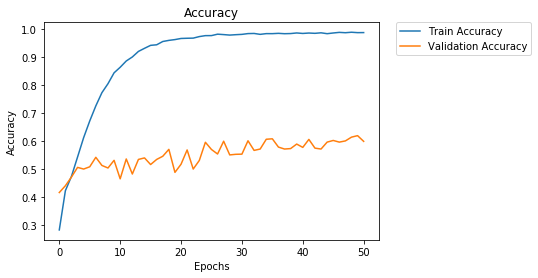

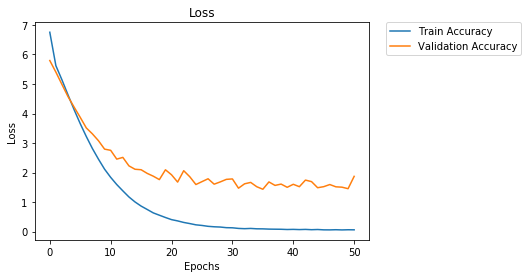

In [19]:
# Visualize train and validation accuracy and loss

epoch_list = list(range(len(history.history['acc'])))
plt.plot(epoch_list, history.history['acc'], label='Train Accuracy')
plt.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

epoch_list = list(range(len(history.history['loss'])))
plt.plot(epoch_list, history.history['loss'], label='Train Accuracy')
plt.plot(epoch_list, history.history['val_loss'], label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [180]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
validate_loss, validate_accuracy = model.evaluate(X_validate, y_validate)

1862/1862 [==============================] - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 12s 6ms/step


In [181]:
print(f"Training accuracy and loss are {round(train_accuracy,2)}, {round(train_loss,2)}, respectively")
print(f"Validation accuracy and loss are {round(validate_accuracy,2)}, {round(validate_loss,2)}, respectively")

Training accuracy and loss are 0.68, 1.11, respectively
Validation accuracy and loss are 0.61, 1.43, respectively



_______________
_______________

### VGG Face

<img src="./images/vgg-face.png" width="360" height="240">

VGGFace model is developed by researcher at Oxford University. This model was developed for face identification and verification, including exploring face alignment and metric learning. The goal of this model is similar to our classificaiton problem which is the reason that this model is chosen.

<a href = "http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf"> Reference</a>

In [85]:
# We create VGG-Face model and load it's weight into the model. Reference of the model and weight is in the readme file.
np.random.seed(28)
set_random_seed(28)

model = models.Sequential()
model.add(layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
model.add(layers.Convolution2D(4096, (7, 7), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Convolution2D(4096, (1, 1), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Convolution2D(2622, (1, 1)))
model.add(layers.Flatten())
model.add(layers.Activation('softmax'))
model.load_weights('D:/Download/Data/vgg_face_weights.h5')

# Fine tuning
x = model.layers[-2].output
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
#x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
#x = layers.Dropout(0.5)(x)
predictions = layers.Dense(8, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

for i, layer in enumerate(model.layers):
   print(i, layer.name)


0 zero_padding2d_14_input
1 zero_padding2d_14
2 conv2d_17
3 zero_padding2d_15
4 conv2d_18
5 max_pooling2d_6
6 zero_padding2d_16
7 conv2d_19
8 zero_padding2d_17
9 conv2d_20
10 max_pooling2d_7
11 zero_padding2d_18
12 conv2d_21
13 zero_padding2d_19
14 conv2d_22
15 zero_padding2d_20
16 conv2d_23
17 max_pooling2d_8
18 zero_padding2d_21
19 conv2d_24
20 zero_padding2d_22
21 conv2d_25
22 zero_padding2d_23
23 conv2d_26
24 max_pooling2d_9
25 zero_padding2d_24
26 conv2d_27
27 zero_padding2d_25
28 conv2d_28
29 zero_padding2d_26
30 conv2d_29
31 max_pooling2d_10
32 conv2d_30
33 dropout_3
34 conv2d_31
35 dropout_4
36 conv2d_32
37 flatten_2
38 dense_4
39 dense_5
40 dense_6


In [86]:
# We unfreeze around 15% of the pretrain model.

for layer in model.layers[:35]:
    layer.trainable = False
for layer in model.layers[35:]:
    layer.trainable = True

# Optimizer Adam is choosen rather than SGD because SGD has longer processing time than Adam.
model.summary()
model.compile(optimizer = optimizers.Adam(lr = 0.0001), loss="categorical_crossentropy", metrics = ['accuracy'])
#model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum=0.9), loss="categorical_crossentropy", metrics = ['accuracy'])
#model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum=0.9), loss="categorical_crossentropy", metrics = [f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_14_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 114, 114, 64)      0         
__________

_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
zero_padding2d_21 (ZeroPaddi (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 512)       1180160   
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 30, 30, 512)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 512)       2359808   
_________________________________________________________________
zero_padding2d_23 (ZeroPaddi (None, 30, 30, 512)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 512)       2359808   
_________________________________________________________________
max_poolin

In [87]:
filepath = r"D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='auto')

early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=15)


history = model.fit_generator(augmentation ,
                              validation_data=[X_validate, y_validate],
                              epochs = 200,
                              steps_per_epoch=len(X_train) /batch_size,
                              callbacks=[checkpoint, early_stop, TQDMNotebookCallback()],
                              verbose = 2,
                              workers = 12)

Epoch 1/200


 - 93s - loss: 7.1417 - acc: 0.4041 - val_loss: 5.3842 - val_acc: 0.5279

Epoch 00001: val_loss improved from inf to 5.38421, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_01-5.38-0.53.h5
Epoch 2/200


 - 84s - loss: 4.3553 - acc: 0.5775 - val_loss: 3.4989 - val_acc: 0.6380

Epoch 00002: val_loss improved from 5.38421 to 3.49893, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_02-3.50-0.64.h5
Epoch 3/200


 - 84s - loss: 3.0008 - acc: 0.6350 - val_loss: 2.5401 - val_acc: 0.6676

Epoch 00003: val_loss improved from 3.49893 to 2.54009, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_03-2.54-0.67.h5
Epoch 4/200


 - 85s - loss: 2.2828 - acc: 0.6556 - val_loss: 1.9979 - val_acc: 0.6864

Epoch 00004: val_loss improved from 2.54009 to 1.99792, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_04-2.00-0.69.h5
Epoch 5/200


 - 82s - loss: 1.8743 - acc: 0.6654 - val_loss: 1.6863 - val_acc: 0.7009

Epoch 00005: val_loss improved from 1.99792 to 1.68629, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_05-1.69-0.70.h5
Epoch 6/200


 - 83s - loss: 1.6186 - acc: 0.6737 - val_loss: 1.4738 - val_acc: 0.7111

Epoch 00006: val_loss improved from 1.68629 to 1.47382, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_06-1.47-0.71.h5
Epoch 7/200


 - 82s - loss: 1.4551 - acc: 0.6804 - val_loss: 1.3314 - val_acc: 0.7143

Epoch 00007: val_loss improved from 1.47382 to 1.33139, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_07-1.33-0.71.h5
Epoch 8/200


 - 83s - loss: 1.3280 - acc: 0.6896 - val_loss: 1.2301 - val_acc: 0.7191

Epoch 00008: val_loss improved from 1.33139 to 1.23012, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_08-1.23-0.72.h5
Epoch 9/200


 - 85s - loss: 1.2368 - acc: 0.6967 - val_loss: 1.1438 - val_acc: 0.7315

Epoch 00009: val_loss improved from 1.23012 to 1.14380, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_09-1.14-0.73.h5
Epoch 10/200


 - 84s - loss: 1.1735 - acc: 0.7010 - val_loss: 1.0911 - val_acc: 0.7325

Epoch 00010: val_loss improved from 1.14380 to 1.09111, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_10-1.09-0.73.h5
Epoch 11/200


 - 85s - loss: 1.1075 - acc: 0.7112 - val_loss: 1.0397 - val_acc: 0.7325

Epoch 00011: val_loss improved from 1.09111 to 1.03969, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_11-1.04-0.73.h5
Epoch 12/200


 - 84s - loss: 1.0689 - acc: 0.7144 - val_loss: 0.9939 - val_acc: 0.7470

Epoch 00012: val_loss improved from 1.03969 to 0.99385, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_12-0.99-0.75.h5
Epoch 13/200


 - 85s - loss: 1.0401 - acc: 0.7157 - val_loss: 0.9695 - val_acc: 0.7492

Epoch 00013: val_loss improved from 0.99385 to 0.96949, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_13-0.97-0.75.h5
Epoch 14/200


 - 84s - loss: 1.0144 - acc: 0.7089 - val_loss: 0.9390 - val_acc: 0.7556

Epoch 00014: val_loss improved from 0.96949 to 0.93900, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_14-0.94-0.76.h5
Epoch 15/200


 - 82s - loss: 0.9896 - acc: 0.7185 - val_loss: 0.9247 - val_acc: 0.7492

Epoch 00015: val_loss improved from 0.93900 to 0.92472, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_15-0.92-0.75.h5
Epoch 16/200


 - 84s - loss: 0.9655 - acc: 0.7210 - val_loss: 0.9005 - val_acc: 0.7513

Epoch 00016: val_loss improved from 0.92472 to 0.90055, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_16-0.90-0.75.h5
Epoch 17/200


 - 84s - loss: 0.9451 - acc: 0.7236 - val_loss: 0.8842 - val_acc: 0.7562

Epoch 00017: val_loss improved from 0.90055 to 0.88417, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_17-0.88-0.76.h5
Epoch 18/200


 - 82s - loss: 0.9389 - acc: 0.7225 - val_loss: 0.8780 - val_acc: 0.7546

Epoch 00018: val_loss improved from 0.88417 to 0.87800, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_18-0.88-0.75.h5
Epoch 19/200


 - 83s - loss: 0.9057 - acc: 0.7324 - val_loss: 0.8665 - val_acc: 0.7562

Epoch 00019: val_loss improved from 0.87800 to 0.86655, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_19-0.87-0.76.h5
Epoch 20/200


 - 82s - loss: 0.9161 - acc: 0.7243 - val_loss: 0.8387 - val_acc: 0.7669

Epoch 00020: val_loss improved from 0.86655 to 0.83872, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_20-0.84-0.77.h5
Epoch 21/200


 - 84s - loss: 0.8892 - acc: 0.7339 - val_loss: 0.8496 - val_acc: 0.7530

Epoch 00021: val_loss did not improve from 0.83872
Epoch 22/200


 - 83s - loss: 0.8904 - acc: 0.7309 - val_loss: 0.8195 - val_acc: 0.7658

Epoch 00022: val_loss improved from 0.83872 to 0.81948, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_22-0.82-0.77.h5
Epoch 23/200


 - 82s - loss: 0.8768 - acc: 0.7369 - val_loss: 0.8031 - val_acc: 0.7701

Epoch 00023: val_loss improved from 0.81948 to 0.80313, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_23-0.80-0.77.h5
Epoch 24/200


 - 82s - loss: 0.8686 - acc: 0.7399 - val_loss: 0.8067 - val_acc: 0.7642

Epoch 00024: val_loss did not improve from 0.80313
Epoch 25/200


 - 82s - loss: 0.8663 - acc: 0.7360 - val_loss: 0.7883 - val_acc: 0.7744

Epoch 00025: val_loss improved from 0.80313 to 0.78830, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_25-0.79-0.77.h5
Epoch 26/200


 - 82s - loss: 0.8507 - acc: 0.7384 - val_loss: 0.7810 - val_acc: 0.7777

Epoch 00026: val_loss improved from 0.78830 to 0.78100, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_26-0.78-0.78.h5
Epoch 27/200


 - 82s - loss: 0.8483 - acc: 0.7403 - val_loss: 0.7743 - val_acc: 0.7830

Epoch 00027: val_loss improved from 0.78100 to 0.77433, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_27-0.77-0.78.h5
Epoch 28/200


 - 83s - loss: 0.8420 - acc: 0.7433 - val_loss: 0.7857 - val_acc: 0.7707

Epoch 00028: val_loss did not improve from 0.77433
Epoch 29/200


 - 84s - loss: 0.8309 - acc: 0.7444 - val_loss: 0.7772 - val_acc: 0.7782

Epoch 00029: val_loss did not improve from 0.77433
Epoch 30/200


 - 85s - loss: 0.8323 - acc: 0.7460 - val_loss: 0.7622 - val_acc: 0.7820

Epoch 00030: val_loss improved from 0.77433 to 0.76220, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_30-0.76-0.78.h5
Epoch 31/200


 - 84s - loss: 0.8238 - acc: 0.7458 - val_loss: 0.7632 - val_acc: 0.7836

Epoch 00031: val_loss did not improve from 0.76220
Epoch 32/200


 - 85s - loss: 0.8175 - acc: 0.7501 - val_loss: 0.7616 - val_acc: 0.7723

Epoch 00032: val_loss improved from 0.76220 to 0.76156, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_32-0.76-0.77.h5
Epoch 33/200


 - 85s - loss: 0.8198 - acc: 0.7474 - val_loss: 0.7570 - val_acc: 0.7760

Epoch 00033: val_loss improved from 0.76156 to 0.75703, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_33-0.76-0.78.h5
Epoch 34/200


 - 85s - loss: 0.8125 - acc: 0.7473 - val_loss: 0.7475 - val_acc: 0.7803

Epoch 00034: val_loss improved from 0.75703 to 0.74753, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_34-0.75-0.78.h5
Epoch 35/200


 - 83s - loss: 0.7992 - acc: 0.7522 - val_loss: 0.7554 - val_acc: 0.7771

Epoch 00035: val_loss did not improve from 0.74753
Epoch 36/200


 - 82s - loss: 0.7969 - acc: 0.7550 - val_loss: 0.7412 - val_acc: 0.7814

Epoch 00036: val_loss improved from 0.74753 to 0.74123, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_36-0.74-0.78.h5
Epoch 37/200


 - 87s - loss: 0.8003 - acc: 0.7482 - val_loss: 0.7351 - val_acc: 0.7841

Epoch 00037: val_loss improved from 0.74123 to 0.73510, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_37-0.74-0.78.h5
Epoch 38/200


 - 82s - loss: 0.7979 - acc: 0.7545 - val_loss: 0.7346 - val_acc: 0.7889

Epoch 00038: val_loss improved from 0.73510 to 0.73456, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_38-0.73-0.79.h5
Epoch 39/200


 - 83s - loss: 0.7790 - acc: 0.7607 - val_loss: 0.7294 - val_acc: 0.7873

Epoch 00039: val_loss improved from 0.73456 to 0.72941, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_39-0.73-0.79.h5
Epoch 40/200


 - 82s - loss: 0.7864 - acc: 0.7555 - val_loss: 0.7321 - val_acc: 0.7803

Epoch 00040: val_loss did not improve from 0.72941
Epoch 41/200


 - 83s - loss: 0.7879 - acc: 0.7550 - val_loss: 0.7154 - val_acc: 0.7965

Epoch 00041: val_loss improved from 0.72941 to 0.71540, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_41-0.72-0.80.h5
Epoch 42/200


 - 83s - loss: 0.7842 - acc: 0.7549 - val_loss: 0.7158 - val_acc: 0.7905

Epoch 00042: val_loss did not improve from 0.71540
Epoch 43/200


 - 84s - loss: 0.7778 - acc: 0.7571 - val_loss: 0.7164 - val_acc: 0.7884

Epoch 00043: val_loss did not improve from 0.71540
Epoch 44/200


 - 83s - loss: 0.7782 - acc: 0.7544 - val_loss: 0.7172 - val_acc: 0.7889

Epoch 00044: val_loss did not improve from 0.71540
Epoch 45/200


 - 84s - loss: 0.7776 - acc: 0.7547 - val_loss: 0.7072 - val_acc: 0.7943

Epoch 00045: val_loss improved from 0.71540 to 0.70724, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_45-0.71-0.79.h5
Epoch 46/200


 - 83s - loss: 0.7592 - acc: 0.7629 - val_loss: 0.7154 - val_acc: 0.7868

Epoch 00046: val_loss did not improve from 0.70724
Epoch 47/200


 - 84s - loss: 0.7610 - acc: 0.7616 - val_loss: 0.7074 - val_acc: 0.7927

Epoch 00047: val_loss did not improve from 0.70724
Epoch 48/200


 - 84s - loss: 0.7722 - acc: 0.7557 - val_loss: 0.7000 - val_acc: 0.7948

Epoch 00048: val_loss improved from 0.70724 to 0.69997, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_48-0.70-0.79.h5
Epoch 49/200


 - 84s - loss: 0.7644 - acc: 0.7598 - val_loss: 0.6998 - val_acc: 0.7916

Epoch 00049: val_loss improved from 0.69997 to 0.69985, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_49-0.70-0.79.h5
Epoch 50/200


 - 84s - loss: 0.7580 - acc: 0.7629 - val_loss: 0.7004 - val_acc: 0.7879

Epoch 00050: val_loss did not improve from 0.69985
Epoch 51/200


 - 82s - loss: 0.7526 - acc: 0.7667 - val_loss: 0.6940 - val_acc: 0.7916

Epoch 00051: val_loss improved from 0.69985 to 0.69396, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_51-0.69-0.79.h5
Epoch 52/200


 - 82s - loss: 0.7583 - acc: 0.7617 - val_loss: 0.6938 - val_acc: 0.7991

Epoch 00052: val_loss improved from 0.69396 to 0.69381, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_52-0.69-0.80.h5
Epoch 53/200


 - 84s - loss: 0.7556 - acc: 0.7608 - val_loss: 0.6957 - val_acc: 0.7938

Epoch 00053: val_loss did not improve from 0.69381
Epoch 54/200


 - 85s - loss: 0.7426 - acc: 0.7651 - val_loss: 0.6917 - val_acc: 0.7922

Epoch 00054: val_loss improved from 0.69381 to 0.69174, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_54-0.69-0.79.h5
Epoch 55/200


 - 83s - loss: 0.7500 - acc: 0.7614 - val_loss: 0.6878 - val_acc: 0.7927

Epoch 00055: val_loss improved from 0.69174 to 0.68782, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_55-0.69-0.79.h5
Epoch 56/200


 - 84s - loss: 0.7475 - acc: 0.7649 - val_loss: 0.6875 - val_acc: 0.7948

Epoch 00056: val_loss improved from 0.68782 to 0.68754, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_56-0.69-0.79.h5
Epoch 57/200


 - 83s - loss: 0.7468 - acc: 0.7661 - val_loss: 0.6895 - val_acc: 0.7948

Epoch 00057: val_loss did not improve from 0.68754
Epoch 58/200


 - 85s - loss: 0.7488 - acc: 0.7654 - val_loss: 0.6781 - val_acc: 0.8034

Epoch 00058: val_loss improved from 0.68754 to 0.67814, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_58-0.68-0.80.h5
Epoch 59/200


 - 85s - loss: 0.7436 - acc: 0.7690 - val_loss: 0.6797 - val_acc: 0.8018

Epoch 00059: val_loss did not improve from 0.67814
Epoch 60/200


 - 83s - loss: 0.7361 - acc: 0.7671 - val_loss: 0.6795 - val_acc: 0.7948

Epoch 00060: val_loss did not improve from 0.67814
Epoch 61/200


 - 85s - loss: 0.7388 - acc: 0.7663 - val_loss: 0.6871 - val_acc: 0.7905

Epoch 00061: val_loss did not improve from 0.67814
Epoch 62/200


 - 83s - loss: 0.7332 - acc: 0.7647 - val_loss: 0.6675 - val_acc: 0.7981

Epoch 00062: val_loss improved from 0.67814 to 0.66752, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_62-0.67-0.80.h5
Epoch 63/200


 - 82s - loss: 0.7443 - acc: 0.7632 - val_loss: 0.6751 - val_acc: 0.7959

Epoch 00063: val_loss did not improve from 0.66752
Epoch 64/200


 - 84s - loss: 0.7269 - acc: 0.7701 - val_loss: 0.6636 - val_acc: 0.8067

Epoch 00064: val_loss improved from 0.66752 to 0.66356, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_64-0.66-0.81.h5
Epoch 65/200


 - 87s - loss: 0.7271 - acc: 0.7714 - val_loss: 0.6646 - val_acc: 0.8034

Epoch 00065: val_loss did not improve from 0.66356
Epoch 66/200


 - 86s - loss: 0.7271 - acc: 0.7686 - val_loss: 0.6741 - val_acc: 0.7991

Epoch 00066: val_loss did not improve from 0.66356
Epoch 67/200


 - 83s - loss: 0.7317 - acc: 0.7685 - val_loss: 0.6620 - val_acc: 0.8024

Epoch 00067: val_loss improved from 0.66356 to 0.66200, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_67-0.66-0.80.h5
Epoch 68/200


 - 83s - loss: 0.7222 - acc: 0.7708 - val_loss: 0.6712 - val_acc: 0.7965

Epoch 00068: val_loss did not improve from 0.66200
Epoch 69/200


 - 84s - loss: 0.7162 - acc: 0.7751 - val_loss: 0.6592 - val_acc: 0.8008

Epoch 00069: val_loss improved from 0.66200 to 0.65917, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_69-0.66-0.80.h5
Epoch 70/200


 - 86s - loss: 0.7267 - acc: 0.7698 - val_loss: 0.6635 - val_acc: 0.8034

Epoch 00070: val_loss did not improve from 0.65917
Epoch 71/200


 - 83s - loss: 0.7165 - acc: 0.7727 - val_loss: 0.6691 - val_acc: 0.7965

Epoch 00071: val_loss did not improve from 0.65917
Epoch 72/200


 - 85s - loss: 0.7225 - acc: 0.7693 - val_loss: 0.6643 - val_acc: 0.7997

Epoch 00072: val_loss did not improve from 0.65917
Epoch 73/200


 - 84s - loss: 0.7079 - acc: 0.7777 - val_loss: 0.6586 - val_acc: 0.7981

Epoch 00073: val_loss improved from 0.65917 to 0.65859, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_73-0.66-0.80.h5
Epoch 74/200


 - 84s - loss: 0.7118 - acc: 0.7756 - val_loss: 0.6528 - val_acc: 0.8061

Epoch 00074: val_loss improved from 0.65859 to 0.65276, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_74-0.65-0.81.h5
Epoch 75/200


 - 86s - loss: 0.7249 - acc: 0.7657 - val_loss: 0.6503 - val_acc: 0.8126

Epoch 00075: val_loss improved from 0.65276 to 0.65034, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_75-0.65-0.81.h5
Epoch 76/200


 - 84s - loss: 0.7083 - acc: 0.7761 - val_loss: 0.6449 - val_acc: 0.8126

Epoch 00076: val_loss improved from 0.65034 to 0.64491, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_76-0.64-0.81.h5
Epoch 77/200


 - 85s - loss: 0.7155 - acc: 0.7705 - val_loss: 0.6528 - val_acc: 0.8002

Epoch 00077: val_loss did not improve from 0.64491
Epoch 78/200


 - 83s - loss: 0.7121 - acc: 0.7756 - val_loss: 0.6419 - val_acc: 0.8104

Epoch 00078: val_loss improved from 0.64491 to 0.64189, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_78-0.64-0.81.h5
Epoch 79/200


 - 83s - loss: 0.7217 - acc: 0.7721 - val_loss: 0.6562 - val_acc: 0.8061

Epoch 00079: val_loss did not improve from 0.64189
Epoch 80/200


 - 87s - loss: 0.6987 - acc: 0.7767 - val_loss: 0.6400 - val_acc: 0.8093

Epoch 00080: val_loss improved from 0.64189 to 0.64003, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_80-0.64-0.81.h5
Epoch 81/200


 - 85s - loss: 0.7083 - acc: 0.7713 - val_loss: 0.6377 - val_acc: 0.8115

Epoch 00081: val_loss improved from 0.64003 to 0.63773, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_81-0.64-0.81.h5
Epoch 82/200


 - 83s - loss: 0.7050 - acc: 0.7783 - val_loss: 0.6396 - val_acc: 0.8088

Epoch 00082: val_loss did not improve from 0.63773
Epoch 83/200


 - 86s - loss: 0.6966 - acc: 0.7782 - val_loss: 0.6371 - val_acc: 0.8077

Epoch 00083: val_loss improved from 0.63773 to 0.63714, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_83-0.64-0.81.h5
Epoch 84/200


 - 87s - loss: 0.7053 - acc: 0.7743 - val_loss: 0.6329 - val_acc: 0.8179

Epoch 00084: val_loss improved from 0.63714 to 0.63292, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_84-0.63-0.82.h5
Epoch 85/200


 - 85s - loss: 0.6978 - acc: 0.7746 - val_loss: 0.6423 - val_acc: 0.8088

Epoch 00085: val_loss did not improve from 0.63292
Epoch 86/200


 - 86s - loss: 0.6924 - acc: 0.7842 - val_loss: 0.6373 - val_acc: 0.8131

Epoch 00086: val_loss did not improve from 0.63292
Epoch 87/200


 - 85s - loss: 0.7004 - acc: 0.7725 - val_loss: 0.6426 - val_acc: 0.8056

Epoch 00087: val_loss did not improve from 0.63292
Epoch 88/200


 - 85s - loss: 0.6941 - acc: 0.7810 - val_loss: 0.6317 - val_acc: 0.8158

Epoch 00088: val_loss improved from 0.63292 to 0.63168, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_88-0.63-0.82.h5
Epoch 89/200


 - 83s - loss: 0.6967 - acc: 0.7762 - val_loss: 0.6340 - val_acc: 0.8147

Epoch 00089: val_loss did not improve from 0.63168
Epoch 90/200


 - 83s - loss: 0.6939 - acc: 0.7737 - val_loss: 0.6385 - val_acc: 0.8163

Epoch 00090: val_loss did not improve from 0.63168
Epoch 91/200


 - 82s - loss: 0.6895 - acc: 0.7743 - val_loss: 0.6372 - val_acc: 0.8120

Epoch 00091: val_loss did not improve from 0.63168
Epoch 92/200


 - 84s - loss: 0.6910 - acc: 0.7767 - val_loss: 0.6376 - val_acc: 0.8077

Epoch 00092: val_loss did not improve from 0.63168
Epoch 93/200


 - 86s - loss: 0.6889 - acc: 0.7753 - val_loss: 0.6436 - val_acc: 0.8040

Epoch 00093: val_loss did not improve from 0.63168
Epoch 94/200


 - 84s - loss: 0.6921 - acc: 0.7775 - val_loss: 0.6241 - val_acc: 0.8190

Epoch 00094: val_loss improved from 0.63168 to 0.62406, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_94-0.62-0.82.h5
Epoch 95/200


 - 82s - loss: 0.6922 - acc: 0.7782 - val_loss: 0.6380 - val_acc: 0.8115

Epoch 00095: val_loss did not improve from 0.62406
Epoch 96/200


 - 82s - loss: 0.6803 - acc: 0.7827 - val_loss: 0.6209 - val_acc: 0.8163

Epoch 00096: val_loss improved from 0.62406 to 0.62086, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_96-0.62-0.82.h5
Epoch 97/200


 - 82s - loss: 0.6780 - acc: 0.7834 - val_loss: 0.6342 - val_acc: 0.8115

Epoch 00097: val_loss did not improve from 0.62086
Epoch 98/200


 - 82s - loss: 0.6895 - acc: 0.7776 - val_loss: 0.6341 - val_acc: 0.8147

Epoch 00098: val_loss did not improve from 0.62086
Epoch 99/200


 - 82s - loss: 0.6884 - acc: 0.7738 - val_loss: 0.6204 - val_acc: 0.8169

Epoch 00099: val_loss improved from 0.62086 to 0.62040, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_99-0.62-0.82.h5
Epoch 100/200


 - 82s - loss: 0.6819 - acc: 0.7807 - val_loss: 0.6194 - val_acc: 0.8120

Epoch 00100: val_loss improved from 0.62040 to 0.61941, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_100-0.62-0.81.h5
Epoch 101/200


 - 83s - loss: 0.6843 - acc: 0.7830 - val_loss: 0.6301 - val_acc: 0.8147

Epoch 00101: val_loss did not improve from 0.61941
Epoch 102/200


 - 84s - loss: 0.6793 - acc: 0.7816 - val_loss: 0.6176 - val_acc: 0.8217

Epoch 00102: val_loss improved from 0.61941 to 0.61764, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_102-0.62-0.82.h5
Epoch 103/200


 - 84s - loss: 0.6844 - acc: 0.7793 - val_loss: 0.6180 - val_acc: 0.8131

Epoch 00103: val_loss did not improve from 0.61764
Epoch 104/200


 - 83s - loss: 0.6752 - acc: 0.7811 - val_loss: 0.6314 - val_acc: 0.8045

Epoch 00104: val_loss did not improve from 0.61764
Epoch 105/200


 - 82s - loss: 0.6837 - acc: 0.7790 - val_loss: 0.6186 - val_acc: 0.8099

Epoch 00105: val_loss did not improve from 0.61764
Epoch 106/200


 - 82s - loss: 0.6799 - acc: 0.7773 - val_loss: 0.6243 - val_acc: 0.8093

Epoch 00106: val_loss did not improve from 0.61764
Epoch 107/200


 - 82s - loss: 0.6827 - acc: 0.7766 - val_loss: 0.6182 - val_acc: 0.8136

Epoch 00107: val_loss did not improve from 0.61764
Epoch 108/200


 - 82s - loss: 0.6796 - acc: 0.7830 - val_loss: 0.6208 - val_acc: 0.8040

Epoch 00108: val_loss did not improve from 0.61764
Epoch 109/200


 - 82s - loss: 0.6742 - acc: 0.7854 - val_loss: 0.6180 - val_acc: 0.8158

Epoch 00109: val_loss did not improve from 0.61764
Epoch 110/200


 - 81s - loss: 0.6729 - acc: 0.7809 - val_loss: 0.6194 - val_acc: 0.8190

Epoch 00110: val_loss did not improve from 0.61764
Epoch 111/200


 - 82s - loss: 0.6768 - acc: 0.7813 - val_loss: 0.6149 - val_acc: 0.8179

Epoch 00111: val_loss improved from 0.61764 to 0.61495, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_111-0.61-0.82.h5
Epoch 112/200


 - 81s - loss: 0.6714 - acc: 0.7821 - val_loss: 0.6068 - val_acc: 0.8206

Epoch 00112: val_loss improved from 0.61495 to 0.60679, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_112-0.61-0.82.h5
Epoch 113/200


 - 81s - loss: 0.6664 - acc: 0.7852 - val_loss: 0.6183 - val_acc: 0.8120

Epoch 00113: val_loss did not improve from 0.60679
Epoch 114/200


 - 81s - loss: 0.6736 - acc: 0.7812 - val_loss: 0.6058 - val_acc: 0.8238

Epoch 00114: val_loss improved from 0.60679 to 0.60581, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_114-0.61-0.82.h5
Epoch 115/200


 - 82s - loss: 0.6760 - acc: 0.7826 - val_loss: 0.6073 - val_acc: 0.8195

Epoch 00115: val_loss did not improve from 0.60581
Epoch 116/200


 - 81s - loss: 0.6760 - acc: 0.7800 - val_loss: 0.6171 - val_acc: 0.8147

Epoch 00116: val_loss did not improve from 0.60581
Epoch 117/200


 - 82s - loss: 0.6699 - acc: 0.7826 - val_loss: 0.6108 - val_acc: 0.8169

Epoch 00117: val_loss did not improve from 0.60581
Epoch 118/200


 - 81s - loss: 0.6817 - acc: 0.7750 - val_loss: 0.6035 - val_acc: 0.8195

Epoch 00118: val_loss improved from 0.60581 to 0.60348, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_118-0.60-0.82.h5
Epoch 119/200


 - 81s - loss: 0.6734 - acc: 0.7815 - val_loss: 0.6124 - val_acc: 0.8147

Epoch 00119: val_loss did not improve from 0.60348
Epoch 120/200


 - 82s - loss: 0.6696 - acc: 0.7788 - val_loss: 0.6094 - val_acc: 0.8147

Epoch 00120: val_loss did not improve from 0.60348
Epoch 121/200


 - 81s - loss: 0.6720 - acc: 0.7827 - val_loss: 0.6031 - val_acc: 0.8174

Epoch 00121: val_loss improved from 0.60348 to 0.60313, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_121-0.60-0.82.h5
Epoch 122/200


 - 82s - loss: 0.6565 - acc: 0.7894 - val_loss: 0.6068 - val_acc: 0.8110

Epoch 00122: val_loss did not improve from 0.60313
Epoch 123/200


 - 82s - loss: 0.6644 - acc: 0.7854 - val_loss: 0.6034 - val_acc: 0.8179

Epoch 00123: val_loss did not improve from 0.60313
Epoch 124/200


 - 82s - loss: 0.6662 - acc: 0.7816 - val_loss: 0.6046 - val_acc: 0.8153

Epoch 00124: val_loss did not improve from 0.60313
Epoch 125/200


 - 82s - loss: 0.6619 - acc: 0.7849 - val_loss: 0.5994 - val_acc: 0.8147

Epoch 00125: val_loss improved from 0.60313 to 0.59937, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_125-0.60-0.81.h5
Epoch 126/200


 - 82s - loss: 0.6532 - acc: 0.7864 - val_loss: 0.6049 - val_acc: 0.8142

Epoch 00126: val_loss did not improve from 0.59937
Epoch 127/200


 - 82s - loss: 0.6603 - acc: 0.7853 - val_loss: 0.6008 - val_acc: 0.8195

Epoch 00127: val_loss did not improve from 0.59937
Epoch 128/200


 - 82s - loss: 0.6625 - acc: 0.7847 - val_loss: 0.6036 - val_acc: 0.8179

Epoch 00128: val_loss did not improve from 0.59937
Epoch 129/200


 - 81s - loss: 0.6685 - acc: 0.7785 - val_loss: 0.6050 - val_acc: 0.8153

Epoch 00129: val_loss did not improve from 0.59937
Epoch 130/200


 - 81s - loss: 0.6600 - acc: 0.7836 - val_loss: 0.6038 - val_acc: 0.8212

Epoch 00130: val_loss did not improve from 0.59937
Epoch 131/200


 - 82s - loss: 0.6689 - acc: 0.7805 - val_loss: 0.5959 - val_acc: 0.8217

Epoch 00131: val_loss improved from 0.59937 to 0.59595, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_131-0.60-0.82.h5
Epoch 132/200


 - 82s - loss: 0.6581 - acc: 0.7838 - val_loss: 0.6012 - val_acc: 0.8169

Epoch 00132: val_loss did not improve from 0.59595
Epoch 133/200


 - 82s - loss: 0.6540 - acc: 0.7863 - val_loss: 0.5974 - val_acc: 0.8169

Epoch 00133: val_loss did not improve from 0.59595
Epoch 134/200


 - 81s - loss: 0.6638 - acc: 0.7843 - val_loss: 0.5965 - val_acc: 0.8163

Epoch 00134: val_loss did not improve from 0.59595
Epoch 135/200


 - 81s - loss: 0.6541 - acc: 0.7846 - val_loss: 0.6042 - val_acc: 0.8163

Epoch 00135: val_loss did not improve from 0.59595
Epoch 136/200


 - 81s - loss: 0.6588 - acc: 0.7863 - val_loss: 0.5979 - val_acc: 0.8217

Epoch 00136: val_loss did not improve from 0.59595
Epoch 137/200


 - 82s - loss: 0.6636 - acc: 0.7785 - val_loss: 0.6006 - val_acc: 0.8147

Epoch 00137: val_loss did not improve from 0.59595
Epoch 138/200


 - 82s - loss: 0.6539 - acc: 0.7870 - val_loss: 0.5972 - val_acc: 0.8153

Epoch 00138: val_loss did not improve from 0.59595
Epoch 139/200


 - 82s - loss: 0.6695 - acc: 0.7826 - val_loss: 0.6056 - val_acc: 0.8136

Epoch 00139: val_loss did not improve from 0.59595
Epoch 140/200


 - 82s - loss: 0.6560 - acc: 0.7862 - val_loss: 0.5990 - val_acc: 0.8174

Epoch 00140: val_loss did not improve from 0.59595
Epoch 141/200


 - 82s - loss: 0.6479 - acc: 0.7837 - val_loss: 0.5929 - val_acc: 0.8169

Epoch 00141: val_loss improved from 0.59595 to 0.59290, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_141-0.59-0.82.h5
Epoch 142/200


 - 81s - loss: 0.6537 - acc: 0.7852 - val_loss: 0.5970 - val_acc: 0.8169

Epoch 00142: val_loss did not improve from 0.59290
Epoch 143/200


 - 82s - loss: 0.6550 - acc: 0.7832 - val_loss: 0.5934 - val_acc: 0.8190

Epoch 00143: val_loss did not improve from 0.59290
Epoch 144/200


 - 82s - loss: 0.6543 - acc: 0.7825 - val_loss: 0.5964 - val_acc: 0.8163

Epoch 00144: val_loss did not improve from 0.59290
Epoch 145/200


 - 82s - loss: 0.6532 - acc: 0.7883 - val_loss: 0.5915 - val_acc: 0.8228

Epoch 00145: val_loss improved from 0.59290 to 0.59150, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_145-0.59-0.82.h5
Epoch 146/200


 - 82s - loss: 0.6584 - acc: 0.7864 - val_loss: 0.5952 - val_acc: 0.8131

Epoch 00146: val_loss did not improve from 0.59150
Epoch 147/200


 - 82s - loss: 0.6474 - acc: 0.7882 - val_loss: 0.5885 - val_acc: 0.8238

Epoch 00147: val_loss improved from 0.59150 to 0.58854, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_147-0.59-0.82.h5
Epoch 148/200


 - 83s - loss: 0.6479 - acc: 0.7848 - val_loss: 0.5942 - val_acc: 0.8201

Epoch 00148: val_loss did not improve from 0.58854
Epoch 149/200


 - 86s - loss: 0.6522 - acc: 0.7870 - val_loss: 0.5885 - val_acc: 0.8217

Epoch 00149: val_loss improved from 0.58854 to 0.58851, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_149-0.59-0.82.h5
Epoch 150/200


 - 86s - loss: 0.6520 - acc: 0.7837 - val_loss: 0.6004 - val_acc: 0.8126

Epoch 00150: val_loss did not improve from 0.58851
Epoch 151/200


 - 89s - loss: 0.6503 - acc: 0.7868 - val_loss: 0.5998 - val_acc: 0.8158

Epoch 00151: val_loss did not improve from 0.58851
Epoch 152/200


 - 88s - loss: 0.6593 - acc: 0.7805 - val_loss: 0.5916 - val_acc: 0.8163

Epoch 00152: val_loss did not improve from 0.58851
Epoch 153/200


 - 89s - loss: 0.6453 - acc: 0.7872 - val_loss: 0.6007 - val_acc: 0.8093

Epoch 00153: val_loss did not improve from 0.58851
Epoch 154/200


 - 89s - loss: 0.6485 - acc: 0.7866 - val_loss: 0.5894 - val_acc: 0.8212

Epoch 00154: val_loss did not improve from 0.58851
Epoch 155/200


 - 88s - loss: 0.6495 - acc: 0.7869 - val_loss: 0.5805 - val_acc: 0.8255

Epoch 00155: val_loss improved from 0.58851 to 0.58048, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_155-0.58-0.83.h5
Epoch 156/200


 - 88s - loss: 0.6462 - acc: 0.7862 - val_loss: 0.5989 - val_acc: 0.8163

Epoch 00156: val_loss did not improve from 0.58048
Epoch 157/200


 - 84s - loss: 0.6562 - acc: 0.7836 - val_loss: 0.5915 - val_acc: 0.8217

Epoch 00157: val_loss did not improve from 0.58048
Epoch 158/200


 - 82s - loss: 0.6476 - acc: 0.7852 - val_loss: 0.5976 - val_acc: 0.8169

Epoch 00158: val_loss did not improve from 0.58048
Epoch 159/200


 - 83s - loss: 0.6476 - acc: 0.7882 - val_loss: 0.5791 - val_acc: 0.8255

Epoch 00159: val_loss improved from 0.58048 to 0.57914, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_159-0.58-0.83.h5
Epoch 160/200


 - 83s - loss: 0.6486 - acc: 0.7885 - val_loss: 0.5884 - val_acc: 0.8158

Epoch 00160: val_loss did not improve from 0.57914
Epoch 161/200


 - 82s - loss: 0.6458 - acc: 0.7847 - val_loss: 0.5821 - val_acc: 0.8179

Epoch 00161: val_loss did not improve from 0.57914
Epoch 162/200


 - 82s - loss: 0.6429 - acc: 0.7891 - val_loss: 0.5849 - val_acc: 0.8201

Epoch 00162: val_loss did not improve from 0.57914
Epoch 163/200


 - 83s - loss: 0.6446 - acc: 0.7842 - val_loss: 0.5900 - val_acc: 0.8212

Epoch 00163: val_loss did not improve from 0.57914
Epoch 164/200


 - 81s - loss: 0.6454 - acc: 0.7858 - val_loss: 0.5817 - val_acc: 0.8244

Epoch 00164: val_loss did not improve from 0.57914
Epoch 165/200


 - 79s - loss: 0.6378 - acc: 0.7886 - val_loss: 0.5934 - val_acc: 0.8120

Epoch 00165: val_loss did not improve from 0.57914
Epoch 166/200


 - 82s - loss: 0.6442 - acc: 0.7864 - val_loss: 0.5812 - val_acc: 0.8260

Epoch 00166: val_loss did not improve from 0.57914
Epoch 167/200


 - 82s - loss: 0.6438 - acc: 0.7879 - val_loss: 0.5929 - val_acc: 0.8126

Epoch 00167: val_loss did not improve from 0.57914
Epoch 168/200


 - 81s - loss: 0.6412 - acc: 0.7901 - val_loss: 0.5782 - val_acc: 0.8238

Epoch 00168: val_loss improved from 0.57914 to 0.57817, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_168-0.58-0.82.h5
Epoch 169/200


 - 84s - loss: 0.6450 - acc: 0.7854 - val_loss: 0.5769 - val_acc: 0.8255

Epoch 00169: val_loss improved from 0.57817 to 0.57693, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_169-0.58-0.83.h5
Epoch 170/200


 - 84s - loss: 0.6408 - acc: 0.7822 - val_loss: 0.5809 - val_acc: 0.8169

Epoch 00170: val_loss did not improve from 0.57693
Epoch 171/200


 - 86s - loss: 0.6366 - acc: 0.7871 - val_loss: 0.5800 - val_acc: 0.8233

Epoch 00171: val_loss did not improve from 0.57693
Epoch 172/200


 - 86s - loss: 0.6453 - acc: 0.7878 - val_loss: 0.5925 - val_acc: 0.8201

Epoch 00172: val_loss did not improve from 0.57693
Epoch 173/200


 - 86s - loss: 0.6539 - acc: 0.7836 - val_loss: 0.5803 - val_acc: 0.8244

Epoch 00173: val_loss did not improve from 0.57693
Epoch 174/200


 - 85s - loss: 0.6356 - acc: 0.7876 - val_loss: 0.5903 - val_acc: 0.8131

Epoch 00174: val_loss did not improve from 0.57693
Epoch 175/200


 - 85s - loss: 0.6421 - acc: 0.7854 - val_loss: 0.5822 - val_acc: 0.8190

Epoch 00175: val_loss did not improve from 0.57693
Epoch 176/200


 - 86s - loss: 0.6438 - acc: 0.7850 - val_loss: 0.5794 - val_acc: 0.8238

Epoch 00176: val_loss did not improve from 0.57693
Epoch 177/200


 - 85s - loss: 0.6338 - acc: 0.7824 - val_loss: 0.5801 - val_acc: 0.8195

Epoch 00177: val_loss did not improve from 0.57693
Epoch 178/200


 - 85s - loss: 0.6345 - acc: 0.7939 - val_loss: 0.5766 - val_acc: 0.8217

Epoch 00178: val_loss improved from 0.57693 to 0.57661, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_178-0.58-0.82.h5
Epoch 179/200


 - 84s - loss: 0.6354 - acc: 0.7883 - val_loss: 0.5764 - val_acc: 0.8201

Epoch 00179: val_loss improved from 0.57661 to 0.57639, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_179-0.58-0.82.h5
Epoch 180/200


 - 88s - loss: 0.6282 - acc: 0.7933 - val_loss: 0.5720 - val_acc: 0.8238

Epoch 00180: val_loss improved from 0.57639 to 0.57200, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_180-0.57-0.82.h5
Epoch 181/200


 - 84s - loss: 0.6353 - acc: 0.7882 - val_loss: 0.5789 - val_acc: 0.8222

Epoch 00181: val_loss did not improve from 0.57200
Epoch 182/200


 - 84s - loss: 0.6387 - acc: 0.7858 - val_loss: 0.5769 - val_acc: 0.8195

Epoch 00182: val_loss did not improve from 0.57200
Epoch 183/200


 - 84s - loss: 0.6366 - acc: 0.7871 - val_loss: 0.5779 - val_acc: 0.8233

Epoch 00183: val_loss did not improve from 0.57200
Epoch 184/200


 - 85s - loss: 0.6343 - acc: 0.7897 - val_loss: 0.5881 - val_acc: 0.8110

Epoch 00184: val_loss did not improve from 0.57200
Epoch 185/200


 - 85s - loss: 0.6333 - acc: 0.7857 - val_loss: 0.5694 - val_acc: 0.8276

Epoch 00185: val_loss improved from 0.57200 to 0.56935, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_185-0.57-0.83.h5
Epoch 186/200


 - 85s - loss: 0.6354 - acc: 0.7890 - val_loss: 0.5798 - val_acc: 0.8190

Epoch 00186: val_loss did not improve from 0.56935
Epoch 187/200


 - 85s - loss: 0.6319 - acc: 0.7897 - val_loss: 0.5782 - val_acc: 0.8185

Epoch 00187: val_loss did not improve from 0.56935
Epoch 188/200


 - 84s - loss: 0.6362 - acc: 0.7880 - val_loss: 0.5740 - val_acc: 0.8222

Epoch 00188: val_loss did not improve from 0.56935
Epoch 189/200


 - 84s - loss: 0.6292 - acc: 0.7950 - val_loss: 0.5813 - val_acc: 0.8185

Epoch 00189: val_loss did not improve from 0.56935
Epoch 190/200


 - 84s - loss: 0.6372 - acc: 0.7876 - val_loss: 0.5770 - val_acc: 0.8131

Epoch 00190: val_loss did not improve from 0.56935
Epoch 191/200


 - 84s - loss: 0.6329 - acc: 0.7891 - val_loss: 0.5827 - val_acc: 0.8153

Epoch 00191: val_loss did not improve from 0.56935
Epoch 192/200


 - 84s - loss: 0.6348 - acc: 0.7858 - val_loss: 0.5695 - val_acc: 0.8222

Epoch 00192: val_loss did not improve from 0.56935
Epoch 193/200


 - 84s - loss: 0.6355 - acc: 0.7849 - val_loss: 0.5835 - val_acc: 0.8158

Epoch 00193: val_loss did not improve from 0.56935
Epoch 194/200


 - 82s - loss: 0.6413 - acc: 0.7871 - val_loss: 0.5742 - val_acc: 0.8217

Epoch 00194: val_loss did not improve from 0.56935
Epoch 195/200


 - 83s - loss: 0.6357 - acc: 0.7872 - val_loss: 0.5839 - val_acc: 0.8174

Epoch 00195: val_loss did not improve from 0.56935
Epoch 196/200


 - 82s - loss: 0.6306 - acc: 0.7890 - val_loss: 0.5732 - val_acc: 0.8217

Epoch 00196: val_loss did not improve from 0.56935
Epoch 197/200


 - 82s - loss: 0.6302 - acc: 0.7895 - val_loss: 0.5683 - val_acc: 0.8238

Epoch 00197: val_loss improved from 0.56935 to 0.56834, saving model to D:\Download\Data\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug\pretrain_197-0.57-0.82.h5
Epoch 198/200


 - 81s - loss: 0.6353 - acc: 0.7873 - val_loss: 0.5717 - val_acc: 0.8265

Epoch 00198: val_loss did not improve from 0.56834
Epoch 199/200


 - 81s - loss: 0.6312 - acc: 0.7854 - val_loss: 0.5786 - val_acc: 0.8201

Epoch 00199: val_loss did not improve from 0.56834
Epoch 200/200


 - 81s - loss: 0.6356 - acc: 0.7873 - val_loss: 0.5768 - val_acc: 0.8195

Epoch 00200: val_loss did not improve from 0.56834


In [94]:
joblib.dump(history, r".\models\pretrain_model\vgg16face\jupyter_Adam - dropout - l2 - 35 layer - aug/pretrain_vgg.pkl")

['.\\models\\pretrain_model\\vgg16face\\jupyter_Adam - dropout - l2 - 35 layer - aug/pretrain_vgg.pkl']

In [95]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
validate_loss, validate_accuracy = model.evaluate(X_validate, y_validate)

1862/1862 [==============================] - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 12s 7ms/step


In [96]:
print(f"Training accuracy and loss are {round(train_accuracy,2)}, {round(train_loss,2)}, respectively")
print(f"Validation accuracy and loss are {round(validate_accuracy,2)}, {round(validate_loss,2)}, respectively")

Training accuracy and loss are 0.88, 0.45, respectively
Validation accuracy and loss are 0.82, 0.58, respectively


Comparing between this 3 models, the pretrain VGG-Face has the highest accuracy with the best generalization than other models. Therefore, we will use this model to predict the age group in the testing dataset and evaluate the model.

______________
____________

### Prediction and Evaluation

In [184]:
yhat = model.predict(X_test)
yhat_int = np.argmax(yhat,axis=1)

#### Confusion matrix

In [185]:
yhat_df = pd.DataFrame(yhat)
yhat_dummy = pd.get_dummies(yhat_df[0])
yhat_cat = to_categorical(yhat_int)

# Convert categorical to integer
y_test_int = np.asarray([np.where(r==1)[0][0] for r in y_test])
con_mat = confusion_matrix(y_test_int, yhat_int, labels=list(range(0,7)))

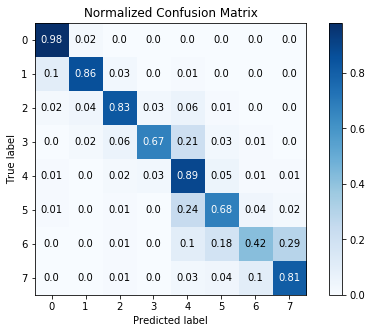

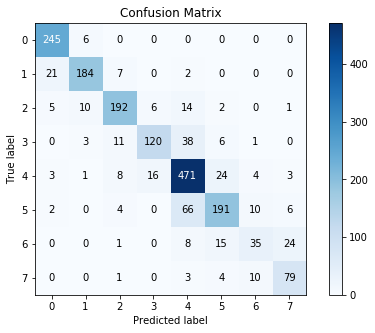

In [186]:
skplt.metrics.plot_confusion_matrix(y_test_int, yhat_int, normalize=True, figsize=(8,5))
skplt.metrics.plot_confusion_matrix(y_test_int, yhat_int, normalize=False, figsize=(8,5))
plt.show()

#### ROC Curve

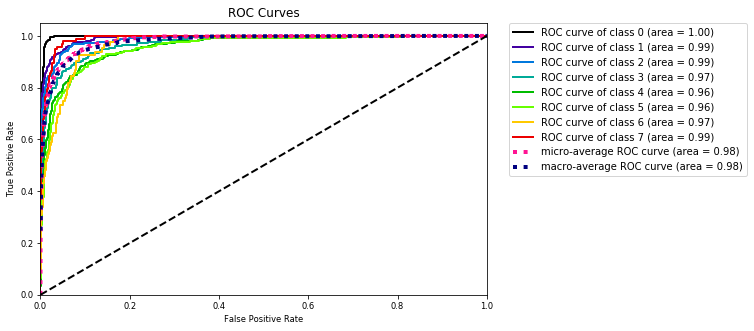

In [100]:
skplt.metrics.plot_roc(y_test_int, yhat, text_fontsize = 'small', figsize = (8,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

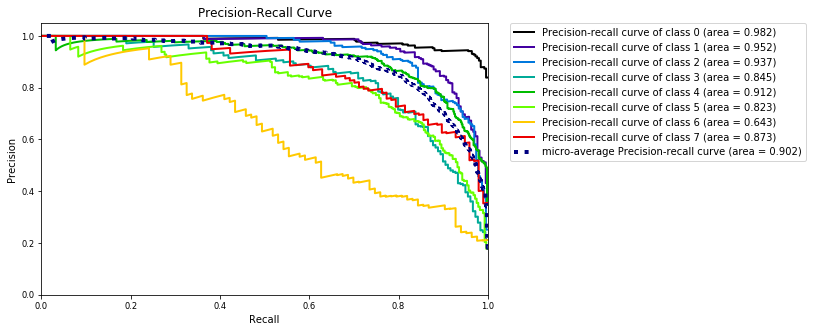

In [101]:
skplt.metrics.plot_precision_recall(y_test_int, yhat, text_fontsize = 'small', figsize = (8,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

In [172]:
f1 = f1_score(y_test_int, yhat_int, average="weighted")
balanced_acc_score = balanced_accuracy_score(y_test_int, yhat_int)
precision = precision_score(y_test_int, yhat_int, average="weighted")
recall= recall_score(y_test_int, yhat_int, average="weighted")

eval_metrics = {}
eval_metrics['recall'] = round(recall,2)
eval_metrics['precision'] = round(precision,2)
eval_metrics['F1_score_weighted'] = round(f1,2)
eval_metrics['balanced_acc_score'] = round(balanced_acc_score,2)


eval_metrics_pd = pd.DataFrame.from_dict(eval_metrics, orient="index")
eval_metrics_pd = eval_metrics_pd.rename(columns={0:"score"})
eval_metrics_pd

,score
recall,0.82
precision,0.82
F1_score_weighted,0.81
balanced_acc_score,0.78


### Result

The prediction from the model shows a very fasinating result which has ROC score almost 0.99 in every classes . The precision-recall area for class 6 is the loweest. This might be due to low number of training samples in the dataset. Weighted score of recall, precision and F1 score more than 0.80

_________________
__________________

### Analysis on Error

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total incorrect images is: 344


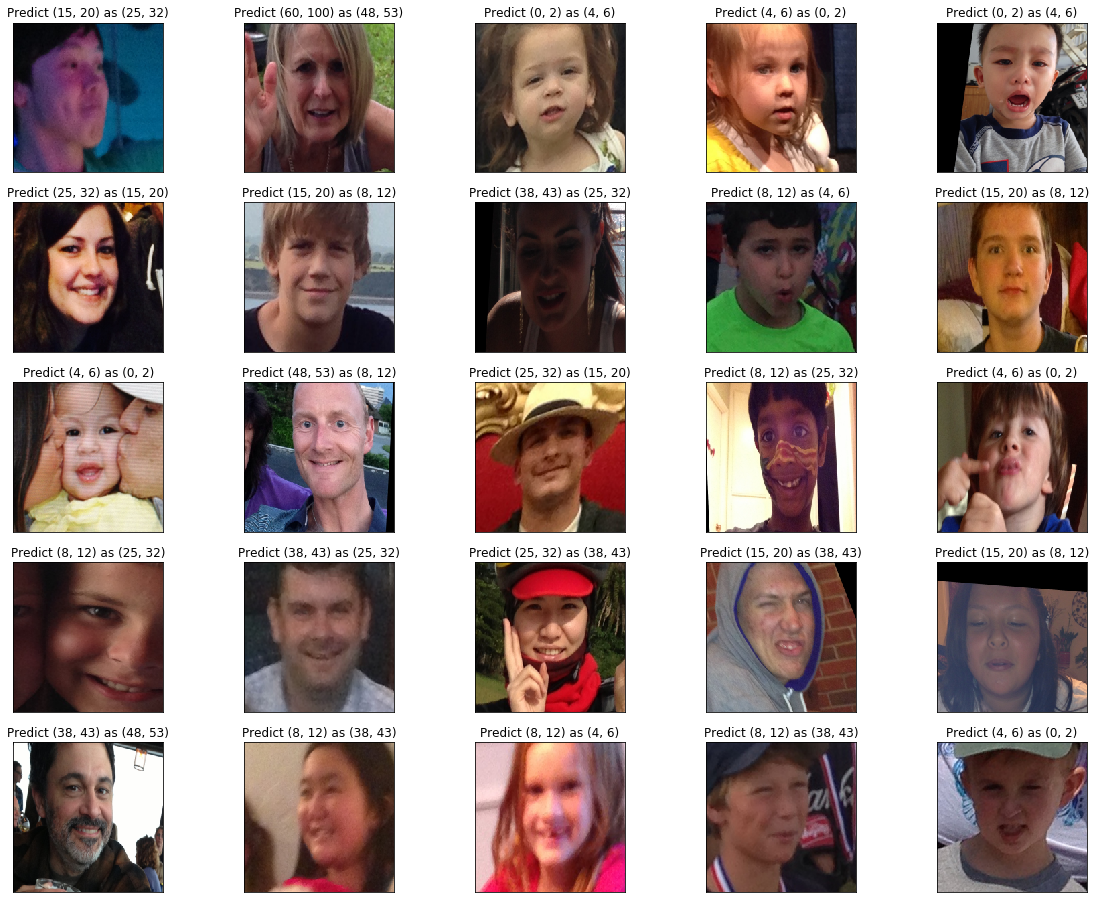

In [107]:
class_dict = dict(list(enumerate(classes)))

# https://www.chegg.com/homework-help/questions-and-answers/working-python-mnist-data-set-numbers-creating-neural-network-issue-following-code-piece-t-q33353531
incorrect_imagenumbers = np.where(yhat_int!=y_test_int)[0] # get indices of incorrect ones
nincorrect = len(incorrect_imagenumbers) 
nsample = 25
samples = np.random.choice(incorrect_imagenumbers, min(nsample, nincorrect), replace=False) 
plt.figure(figsize =(20,16)) 
for i,sample in enumerate(samples):  
    #print(i,sample)
    writer = X_test[sample]
    plt.subplot (5, 5, i+1) 
    plt.imshow(cv2.cvtColor(writer, cv2.COLOR_BGR2RGB))
    plt.title('Predict ' + class_dict[y_test_int[sample]] + ' as ' + class_dict[yhat_int[sample]] )
    plt.xticks([]) 
    plt.yticks([])

print("Total incorrect images is:", nincorrect)

### Limitation and Future Improvement

<div style = "text-align: justify"> &emsp; There are several limitations in our study. Firstly, the way we import the image for training, validation and test set might be bias. The image files are separated into fold 0 to fold 4, each folder has the image of ther same person but from different angle. But, we selected all images from all the folders into single list and shuffle the images to separated into train, validate and test datasets. There are chances that the same person could be in train, validate and test dataset which could lead to bias in accuracy.
Secondly, due to architecture from the VGGFace, the high dropout rate in dropout layers might cause the over generalization of the model. Thirdly, the technical preparation might not be as efficient. Because the way we conduct the experiment we import all images in the RAM which required huge amount of memory. Moreover, the dataset used this study is aligned-face which might not be generalize when predict other non-aligned face images.
<br><br>
&emsp; The experiment could be improve by separate the folders into train, validate and test dataset directly as it would prevent from the same person in each datasets. Also, there is newer VGGFace 2 pretrain model available with is trained from larger samples which should give better performance. To be more efficient and reduce computational resource, the flow of the image should come from the directory rather than from the memory. We could add non-alighed face image for training with the marked location of faced to increase the precision. </div>